<a href="https://colab.research.google.com/github/JoseFPortoles/Segnet-in-Keras/blob/master/Segnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Keras ```MaxPooling2D``` layer with argmax indices extraction 

### $\color{green}{\text{Approach:}}$
Examining tf.keras.layers it looks like MaxPooling2D layers calls a funtion ```tf.nn.maxpool()``` for the maxpooling operation ([src](https://github.com/tensorflow/tensorflow/blob/v2.2.0/tensorflow/python/keras/layers/pooling.py)).

More exactly, the ```MaxPooling2D``` class inherits from class ```Pooling2D``` and calls the parent's ```__init()__``` method from its own, passing ```it tf.nn.maxpool``` as a parameter 

The approach followed here is to create a new class ```ArgMaxPooling2D``` that also calls ```Pooling2D.__init()__``` from its own ```__init()__``` method, but this time passing the function ```tf.nn.max_pool_with_argmax()```. The last function returns a tuple of two tensors; the first one the Maxpooled input tensor and the second one containing the argmax flattened index. The flattened index changes depending on the value of flag ```include_batch_in_index```

* ```include_batch_in_index = True```: The index corresponds to scanning the whole input tensor in the order: batch index, x, y, c ; therefore 

  ```index = ((b*height + y)*width + x)*channels + c```

* ```include_batch_in_index = False```: The index corresponds to scanning the current sample in the input tensor in the order: x, y, c ; therefore

  ```index = (y*width + x)*channels + c```








## Import some general stuff

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model

## Create custom MaxPooling layer 
Create a custom layer 

In [ ]:
from tensorflow.python.keras.layers.pooling import Pooling2D, MaxPooling2D
from tensorflow import nn
class ArgMaxPooling2D(Pooling2D):

  def __init__(self,
               pool_size=(1,1),
               strides=None,
               padding='VALID',
               data_format=None,
               **kwargs):
    super(ArgMaxPooling2D, self).__init__(
        self.max_pool_with_argmax,
        pool_size=pool_size, strides=strides,
        padding=padding, data_format=data_format, **kwargs)
  def get_config(self):
    config = super().get_config()
    return config

  def max_pool_with_argmax(self,
                           input,
                           ksize,
                           strides,
                           padding,
                           data_format='NHWC',
                           output_dtype=tf.dtypes.int64,
                           include_batch_in_index=False,
                           name=None):
    return nn.max_pool_with_argmax(input=input,
                                   ksize=ksize,
                                   strides=strides,
                                   padding=padding,
                                   data_format=data_format,
                                   output_dtype=output_dtype,
                                   include_batch_in_index=include_batch_in_index,
                                   name=name)


## Test ArgMaxPooling

### Test a single layer

In [ ]:
max_pool_2d.get_config()

{'data_format': 'channels_last',
 'dtype': 'float32',
 'name': 'max_pooling2d_2',
 'padding': 'valid',
 'pool_size': (2, 2),
 'strides': (1, 1),
 'trainable': True}

In [ ]:
 x = tf.constant([[[[1.,1.5], [2.,2.5], [3.,3.5]],
                   [[4.,4.5], [5.,5.5], [6.,6.5]],
                   [[7.,7.5], [8.,8.5], [9.,9.5]]],
                  [[[3.,3.5], [2.,2.5], [1.,1.5]],
                   [[4.,4.5], [5.,5.5], [6.,6.5]],
                   [[9.,9.5], [8.,8.5], [7.,7.5]]]])
print('Result with ArgMaxPooling:')
max_pool_2d = ArgMaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='VALID')
print(x)
print(max_pool_2d(x))
print('Result with MaxPooling:')
max_pool_2d = MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='VALID')
print(max_pool_2d(x))

Result with ArgMaxPooling:
tf.Tensor(
[[[[1.  1.5]
   [2.  2.5]
   [3.  3.5]]

  [[4.  4.5]
   [5.  5.5]
   [6.  6.5]]

  [[7.  7.5]
   [8.  8.5]
   [9.  9.5]]]


 [[[3.  3.5]
   [2.  2.5]
   [1.  1.5]]

  [[4.  4.5]
   [5.  5.5]
   [6.  6.5]]

  [[9.  9.5]
   [8.  8.5]
   [7.  7.5]]]], shape=(2, 3, 3, 2), dtype=float32)
MaxPoolWithArgmax(output=<tf.Tensor: shape=(2, 2, 2, 2), dtype=float32, numpy=
array([[[[5. , 5.5],
         [6. , 6.5]],

        [[8. , 8.5],
         [9. , 9.5]]],


       [[[5. , 5.5],
         [6. , 6.5]],

        [[9. , 9.5],
         [8. , 8.5]]]], dtype=float32)>, argmax=<tf.Tensor: shape=(2, 2, 2, 2), dtype=int64, numpy=
array([[[[ 8,  9],
         [10, 11]],

        [[14, 15],
         [16, 17]]],


       [[[ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15]]]])>)
Result with MaxPooling:
tf.Tensor(
[[[[5.  5.5]
   [6.  6.5]]

  [[8.  8.5]
   [9.  9.5]]]


 [[[5.  5.5]
   [6.  6.5]]

  [[9.  9.5]
   [8.  8.5]]]], shape=(2, 2, 2, 2), dtype=f

### Test a complete encoder
From an Imagenet pretrained vgg16 encoder, create a new encoder by substituting the original Maxpool2D layers by the new ArgMaxPool2D layers.

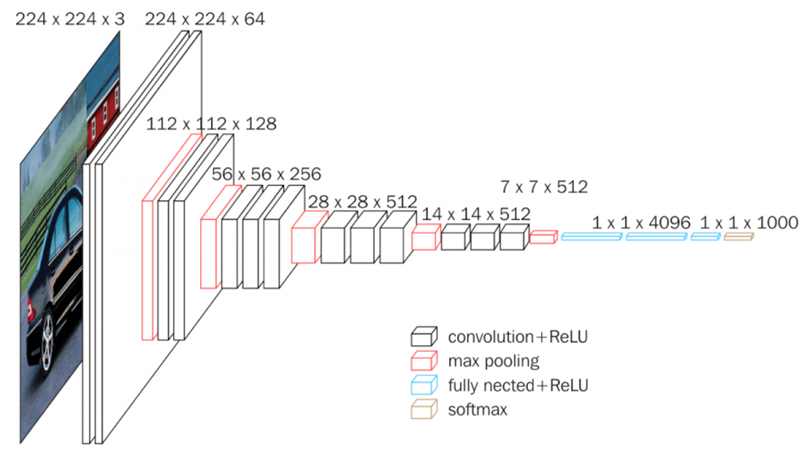



#### Instantiate the pretrained vgg16 model
instantiate a vgg16 model with Imagenet weights. Remove the classifying head as we want to use it as an encoder.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

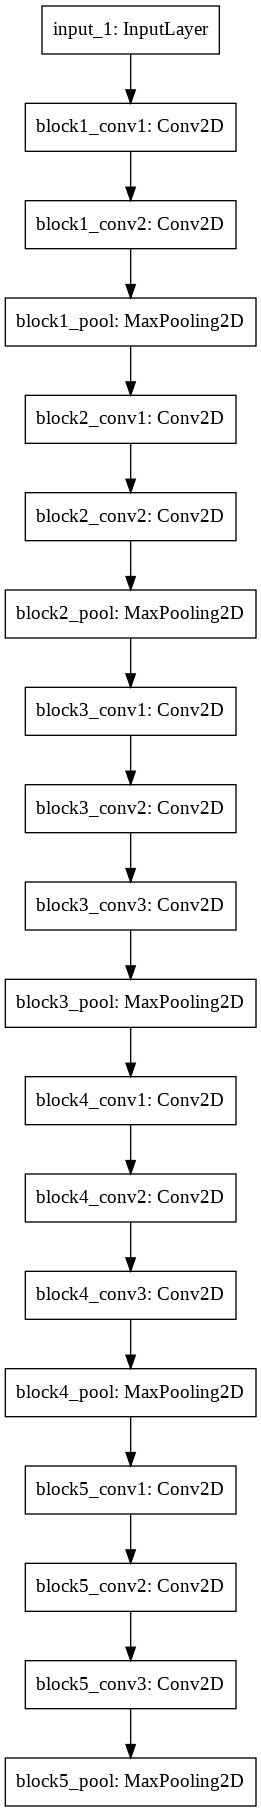

In [ ]:
from tensorflow.keras.applications import VGG16
vgg = VGG16(weights='imagenet', include_top=False)
vgg.summary()
plot_model(vgg, to_file='vgg_graph.png')

#### Create new model with ArgMaxPool2D layers 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input

img_w = 224
img_h = 224

idx_dict = dict()

input_tensor = Input(shape=(img_h, img_w, 3))

#Use keras functional model to rebuild the vgg model layer by layer swapping the MaxPool2D layers by ArgMaxPool2D
x = input_tensor
for layer in vgg.layers:
  if 'pool' in layer.name:
    argmaxname = layer.name.split('_')[0] + '_argmaxpool'
    x = ArgMaxPooling2D(pool_size=(2, 2), strides=(2,2), name=argmaxname)(x)
    idx_dict[layer.name] = x[1]
    x = x[0] #Feed the maxpooled input tensor, but not the indices
  elif 'input' in layer.name:
    continue
  else:
    x = layer(x)

encoder = Model(input_tensor,x)

encoder.summary()
plot_model(encoder, to_file='encoder_graph.png')

#### Compare the new model with the original vgg16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

model1 = VGG16(weights='imagenet', include_top=False)
model2 = model

img_path = '/content/drive/My Drive/data/elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features1 = model1.predict(x)
features2 = model2.predict(x)
f_width = features1.shape[1]
f_number = features1.shape[-1]
features = np.append(features1,100*np.ones((1,f_width,1,f_number)),axis=2)
features = np.append(features,features2,axis=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


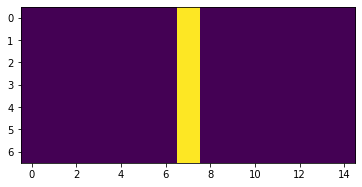

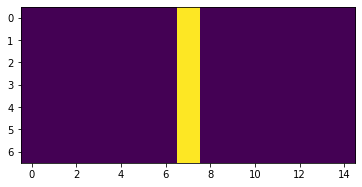

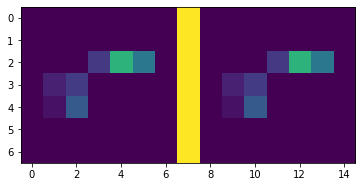

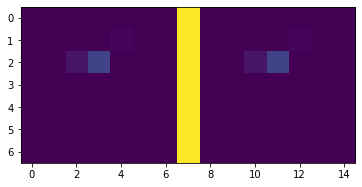

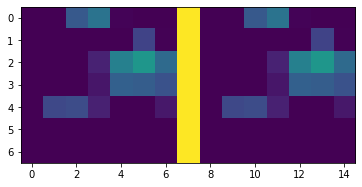

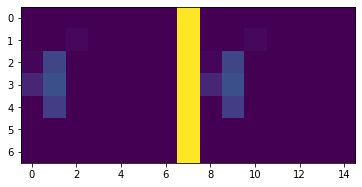

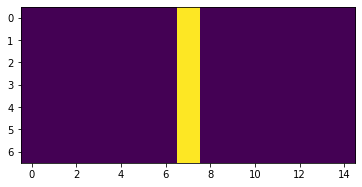

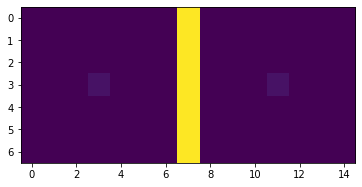

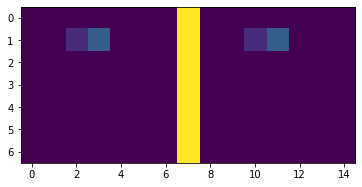

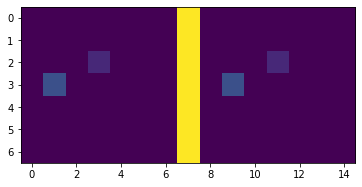

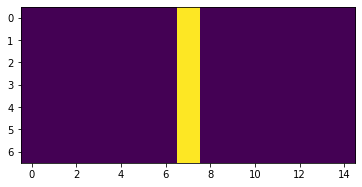

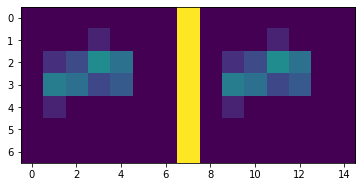

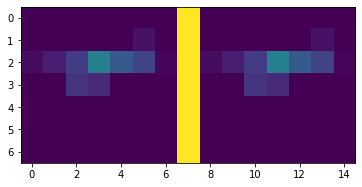

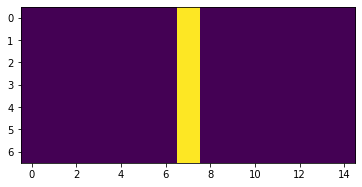

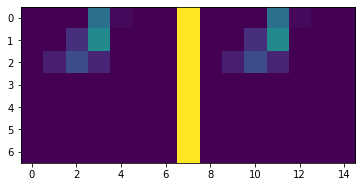

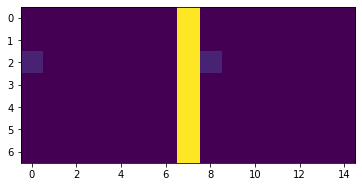

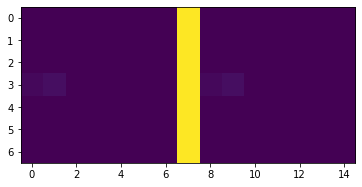

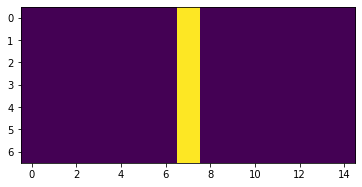

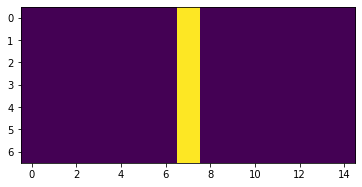

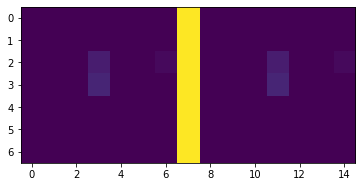

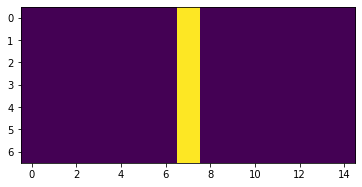

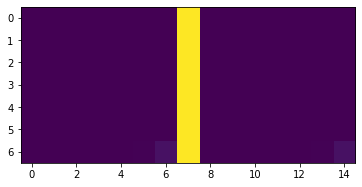

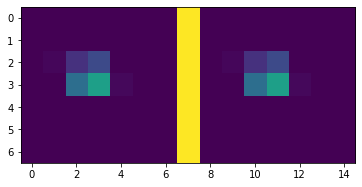

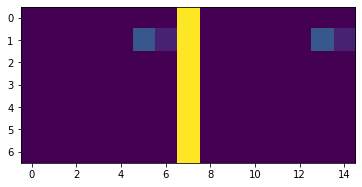

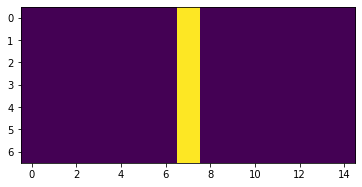

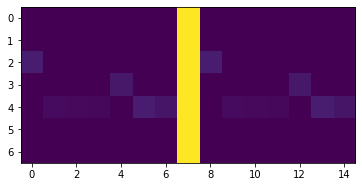

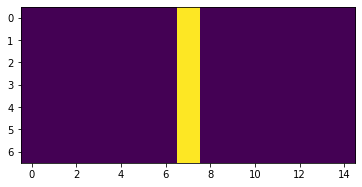

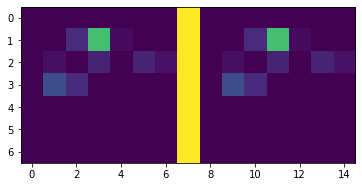

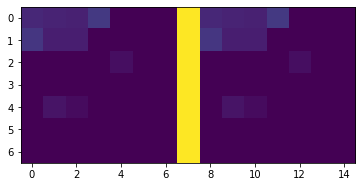

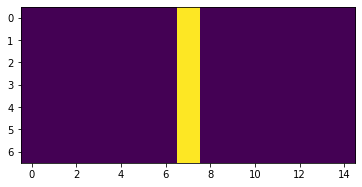

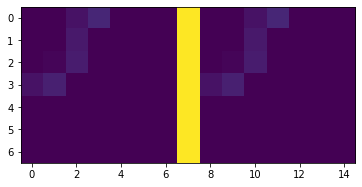

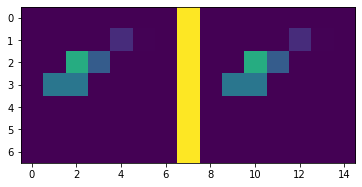

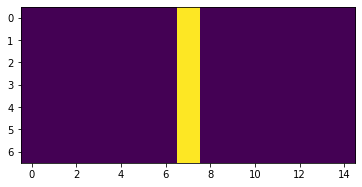

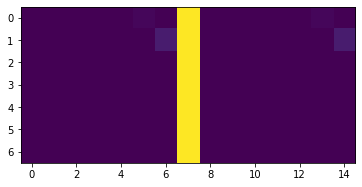

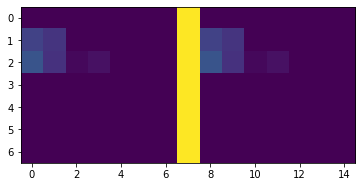

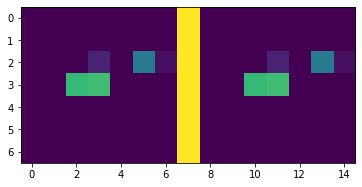

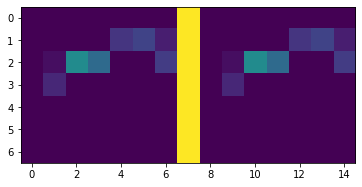

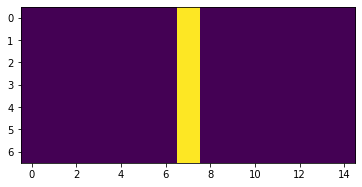

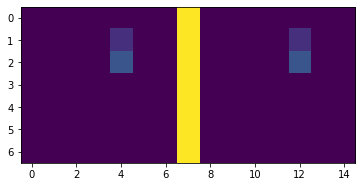

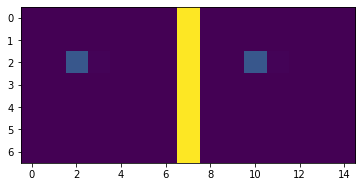

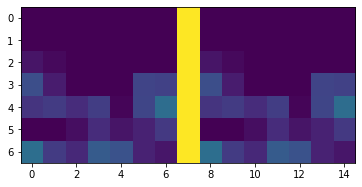

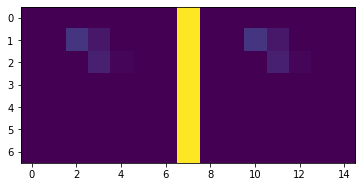

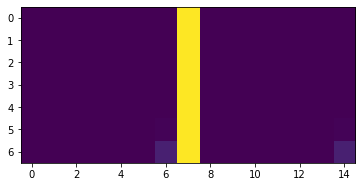

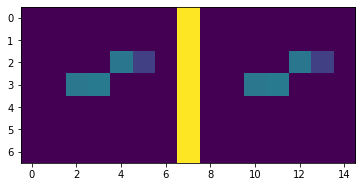

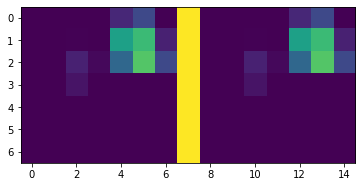

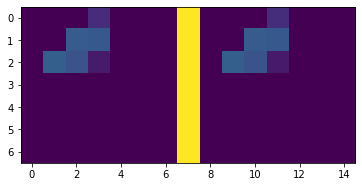

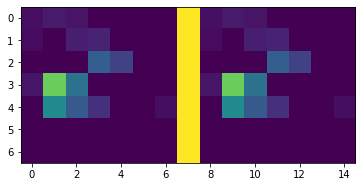

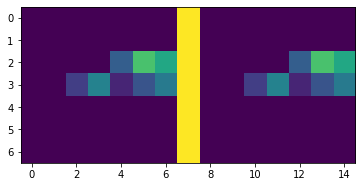

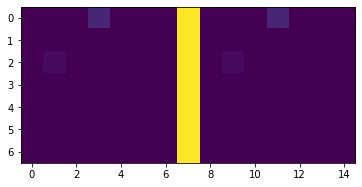

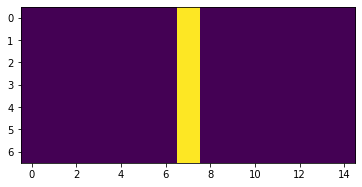

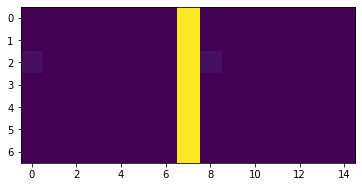

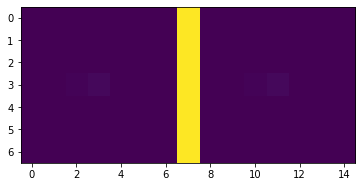

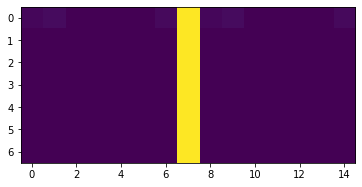

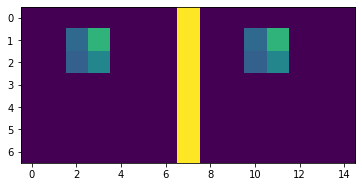

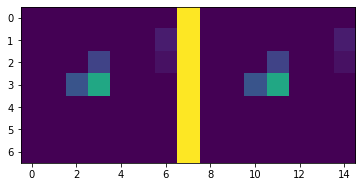

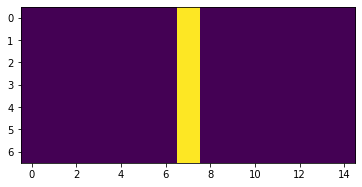

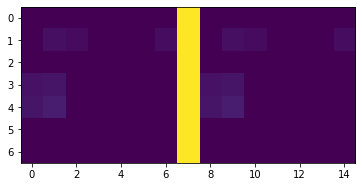

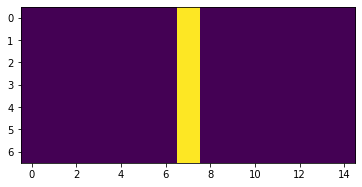

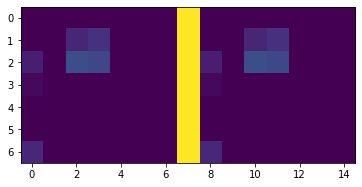

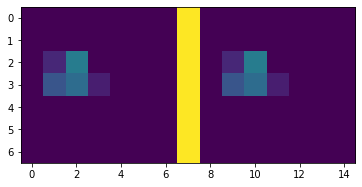

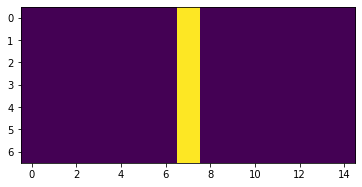

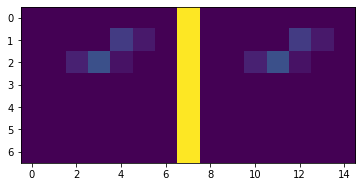

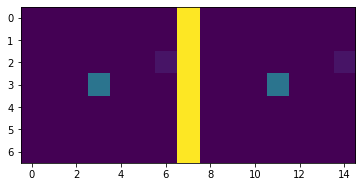

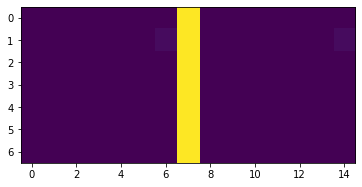

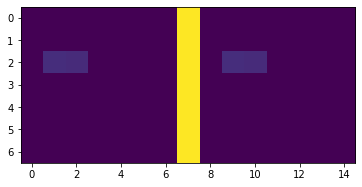

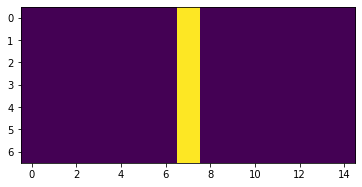

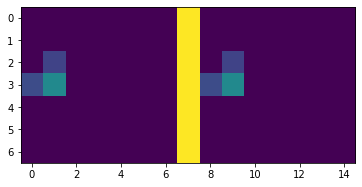

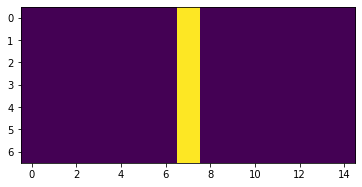

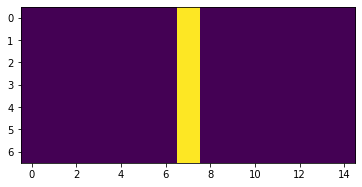

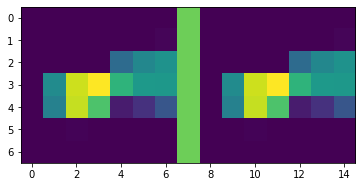

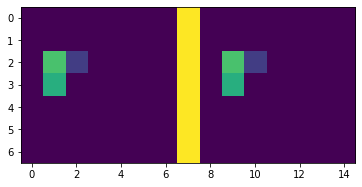

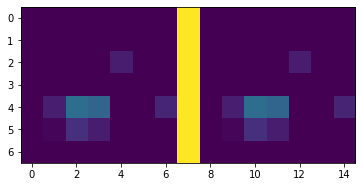

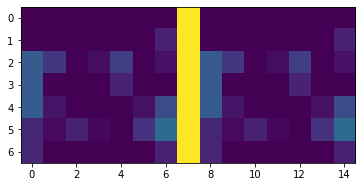

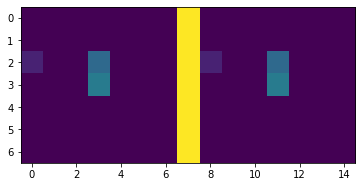

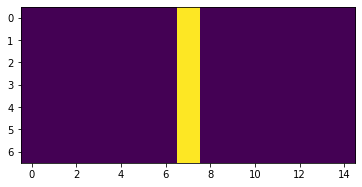

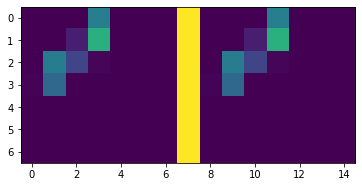

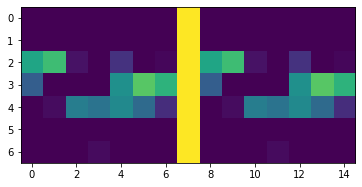

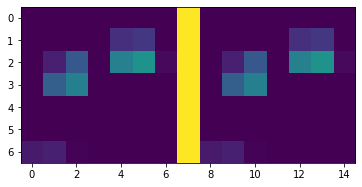

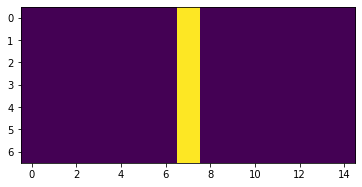

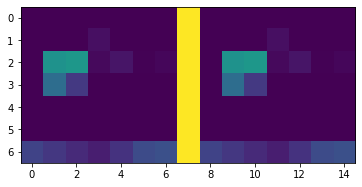

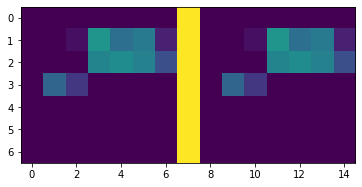

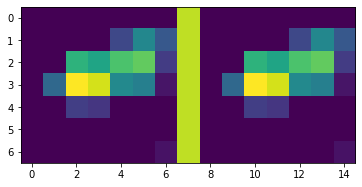

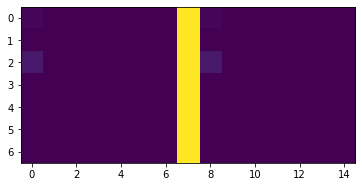

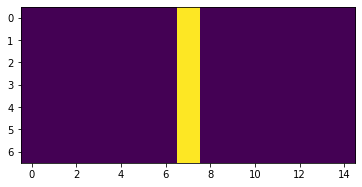

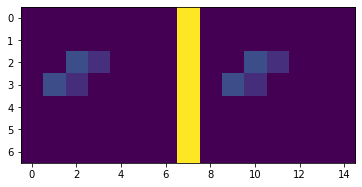

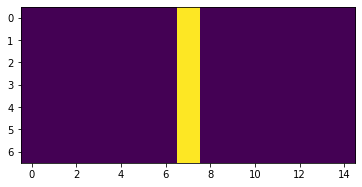

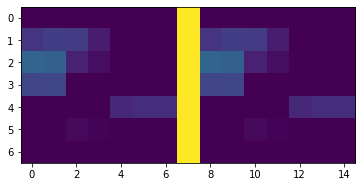

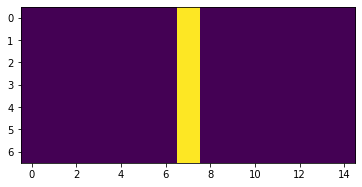

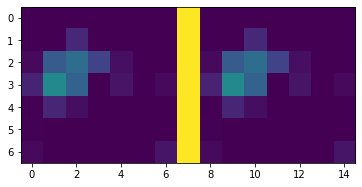

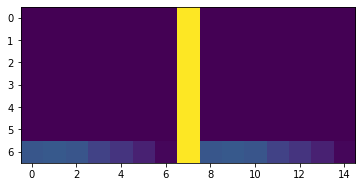

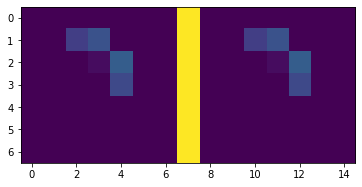

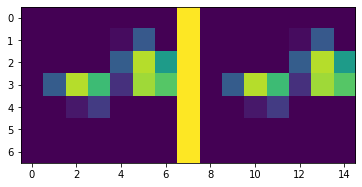

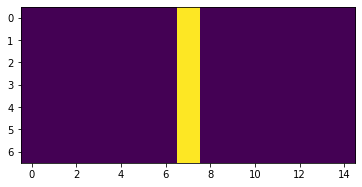

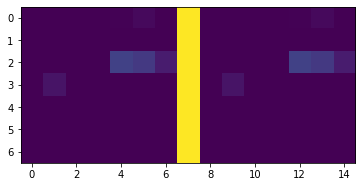

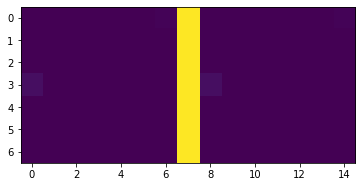

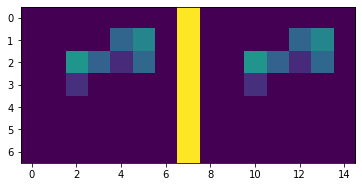

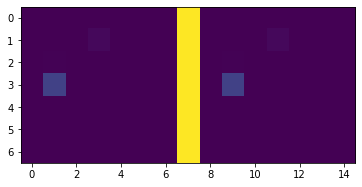

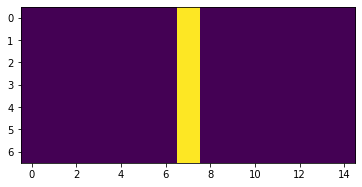

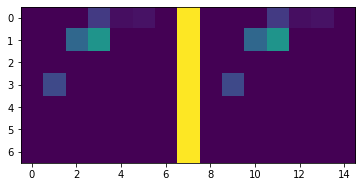

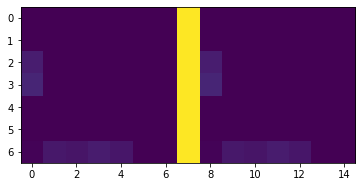

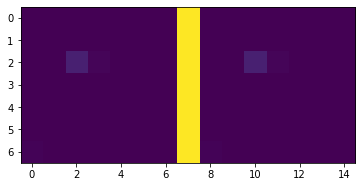

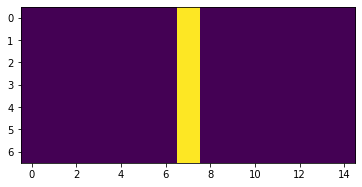

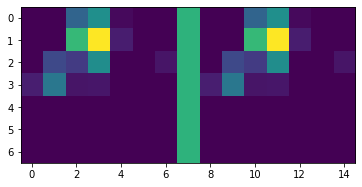

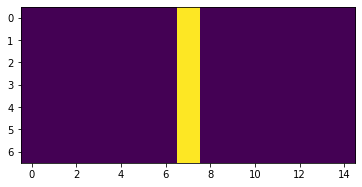

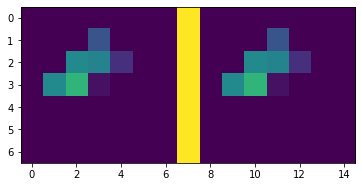

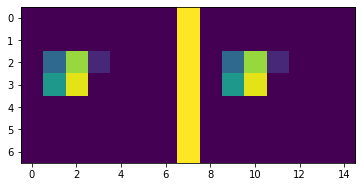

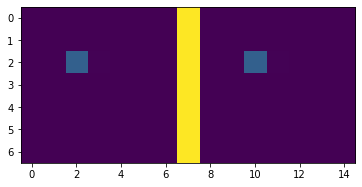

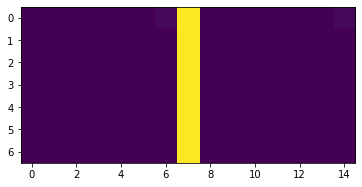

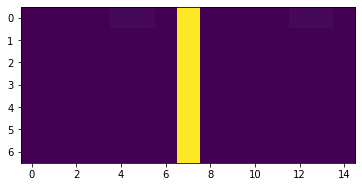

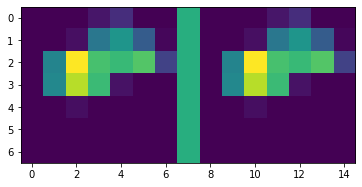

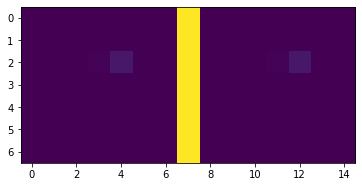

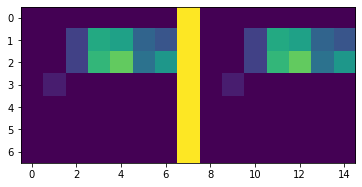

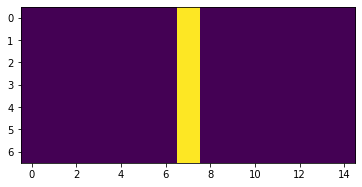

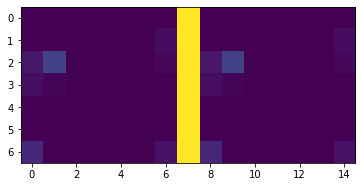

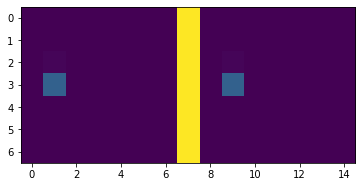

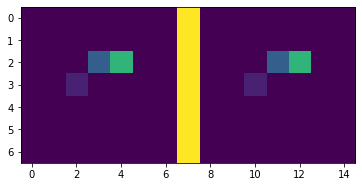

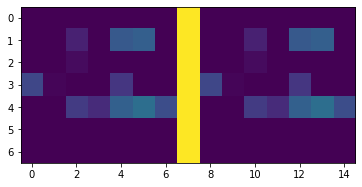

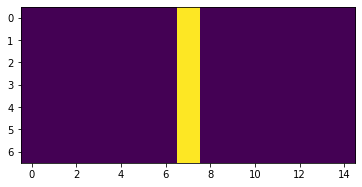

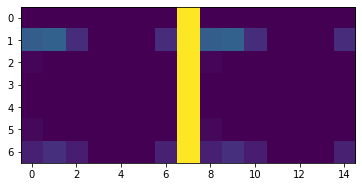

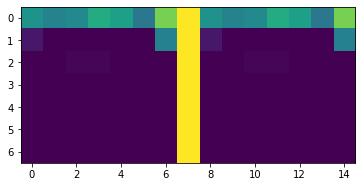

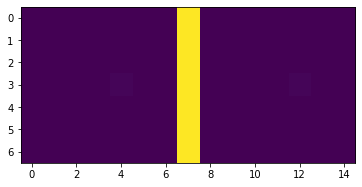

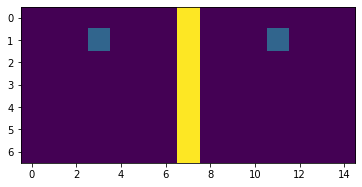

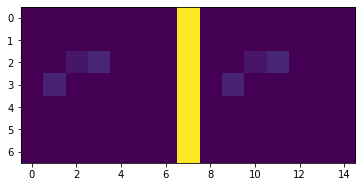

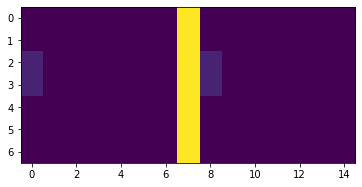

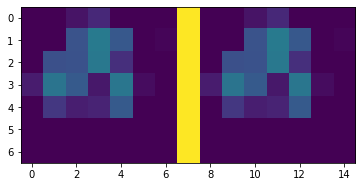

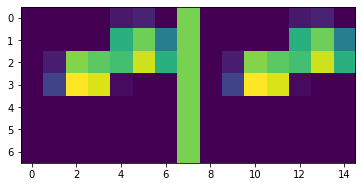

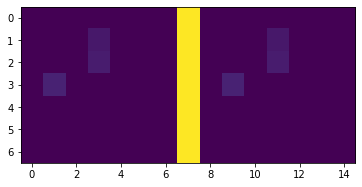

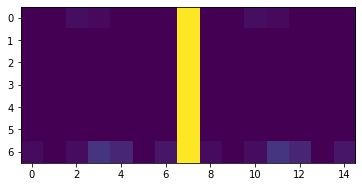

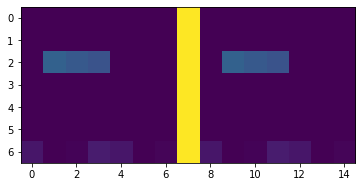

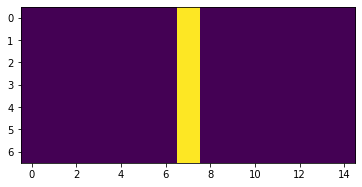

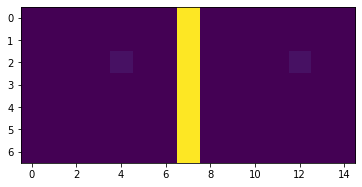

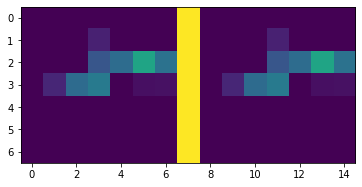

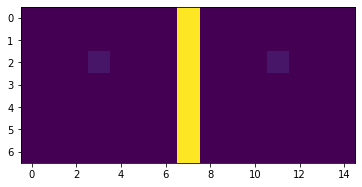

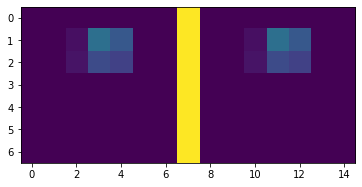

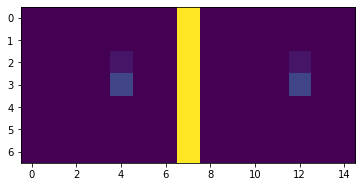

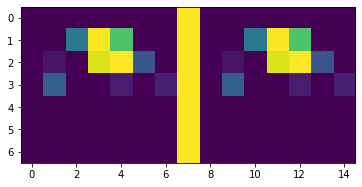

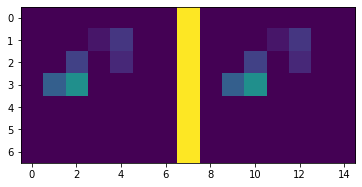

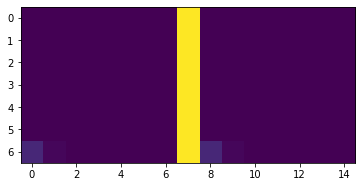

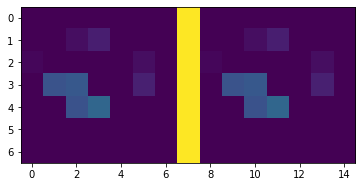

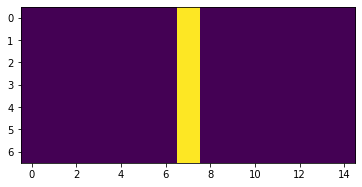

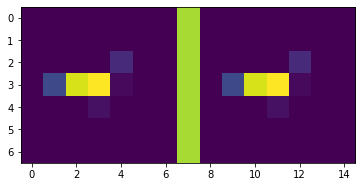

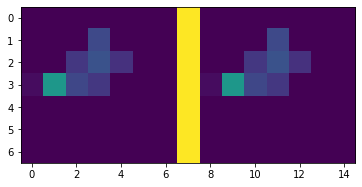

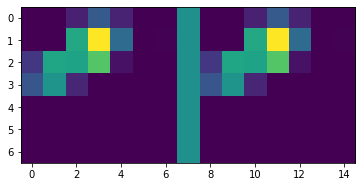

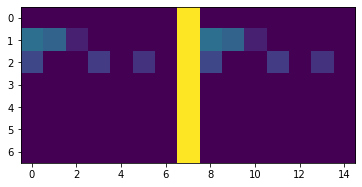

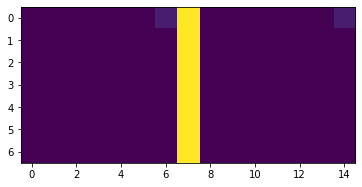

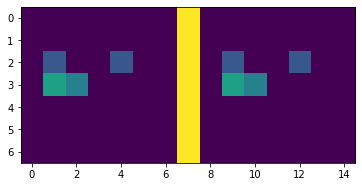

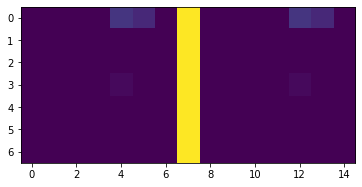

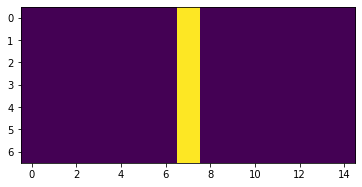

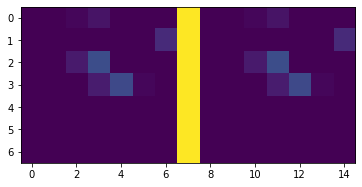

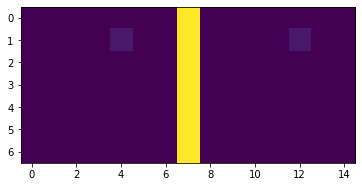

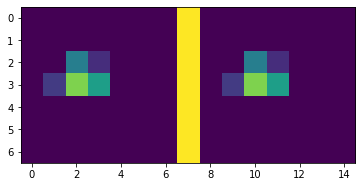

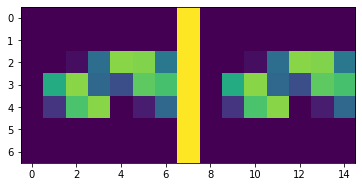

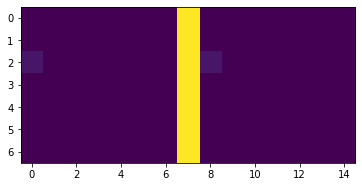

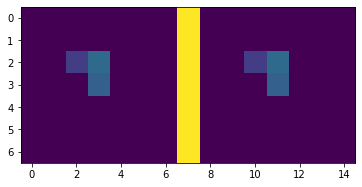

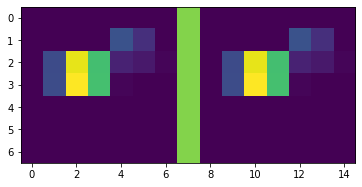

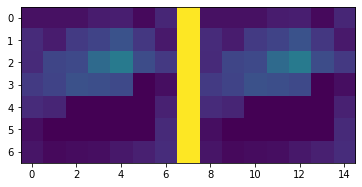

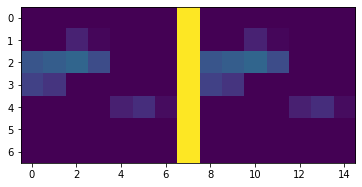

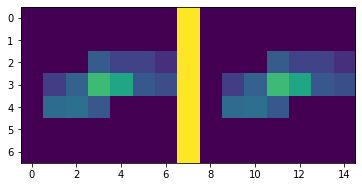

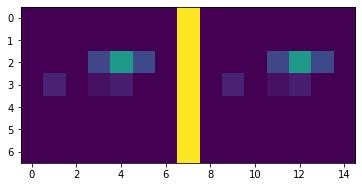

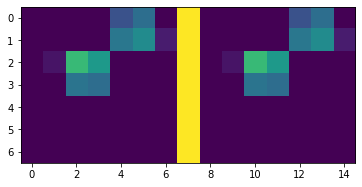

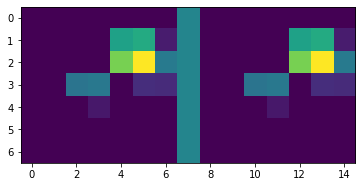

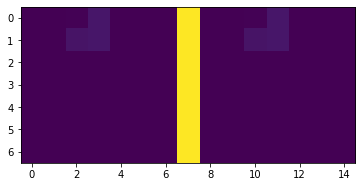

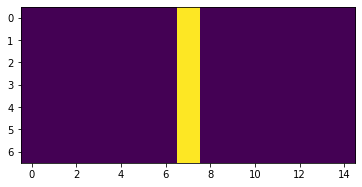

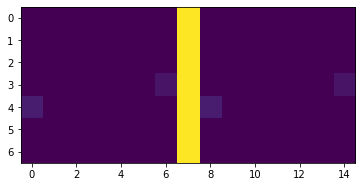

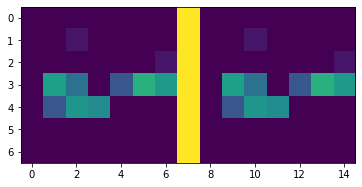

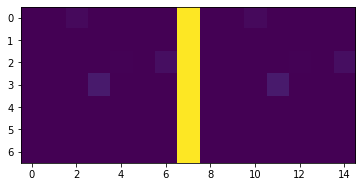

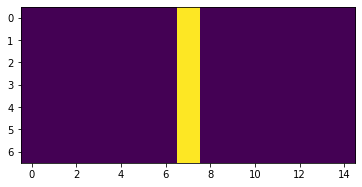

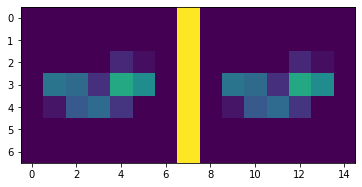

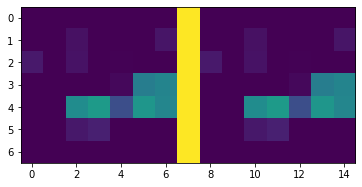

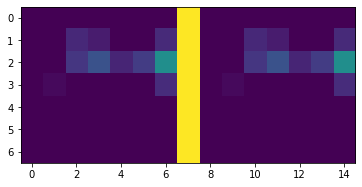

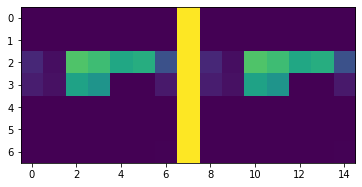

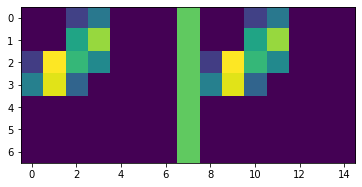

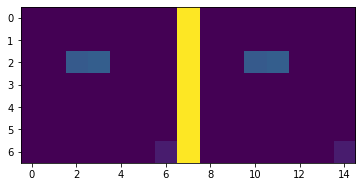

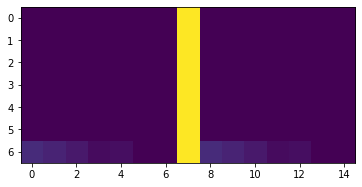

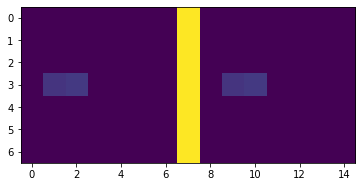

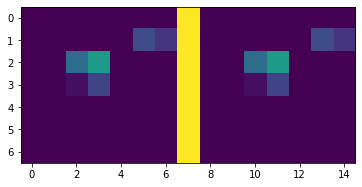

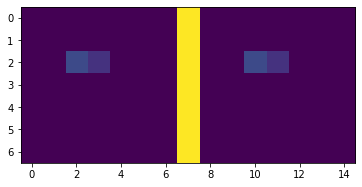

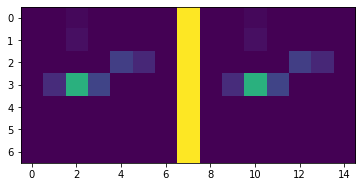

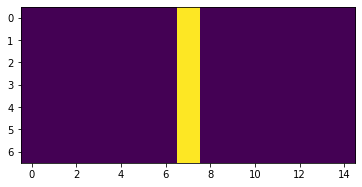

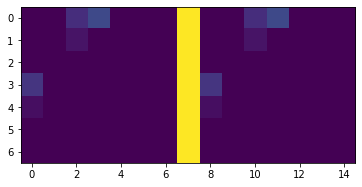

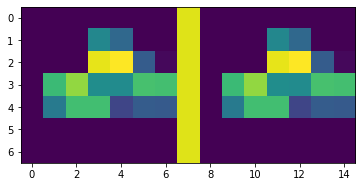

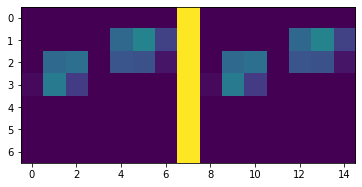

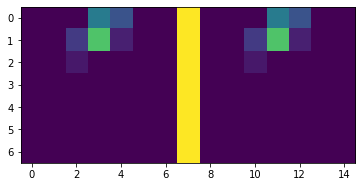

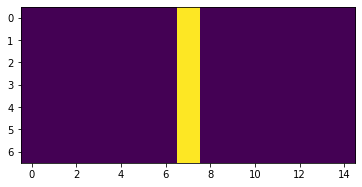

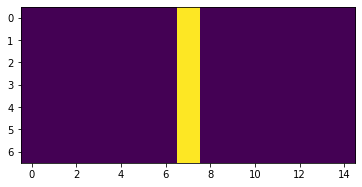

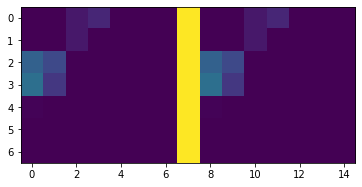

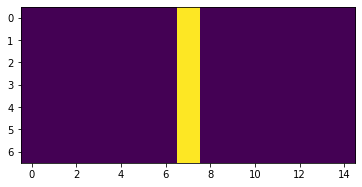

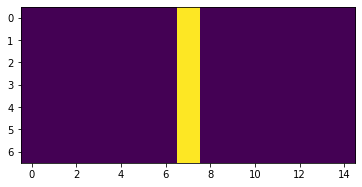

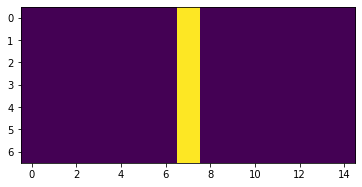

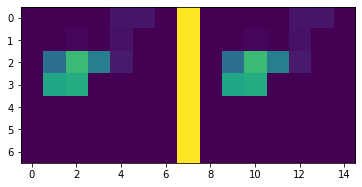

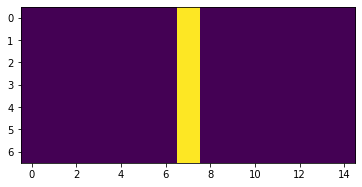

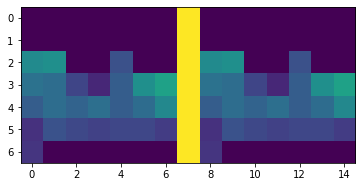

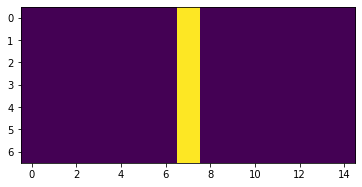

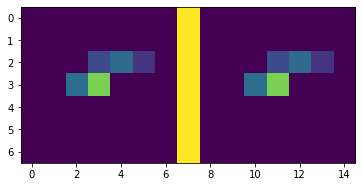

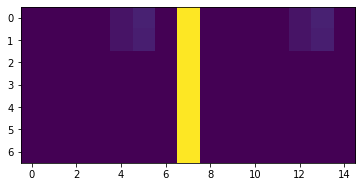

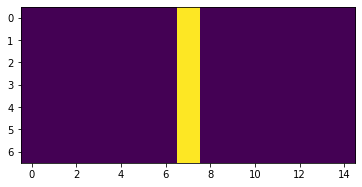

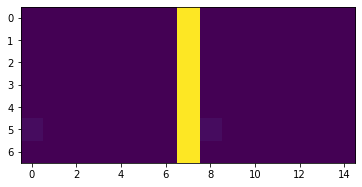

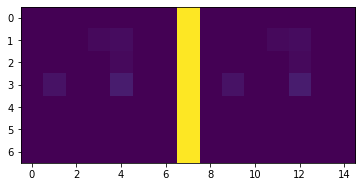

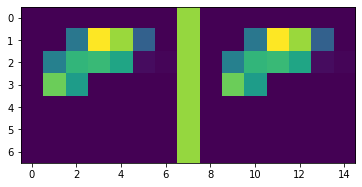

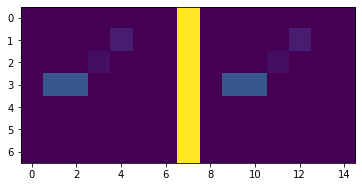

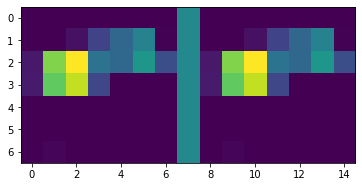

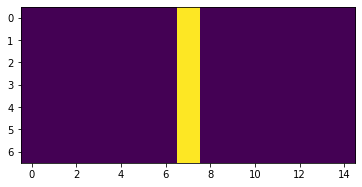

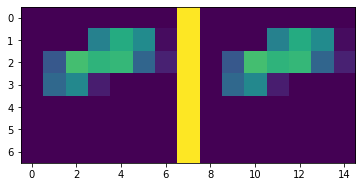

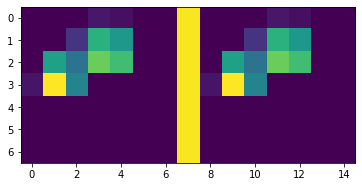

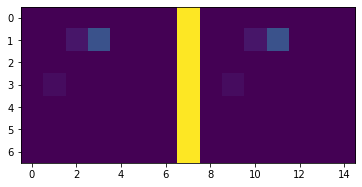

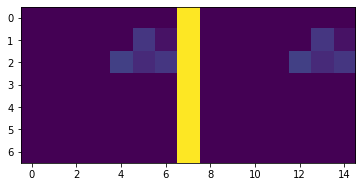

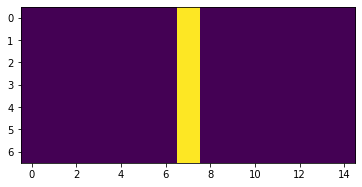

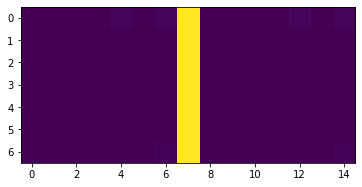

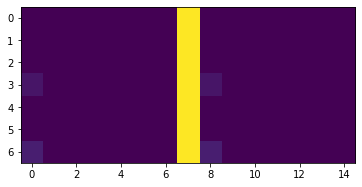

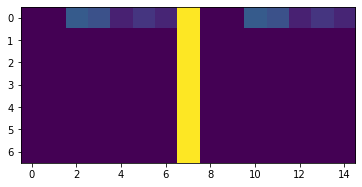

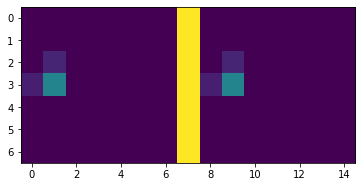

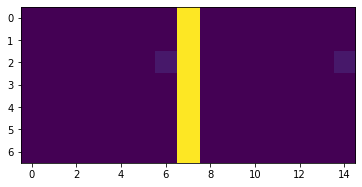

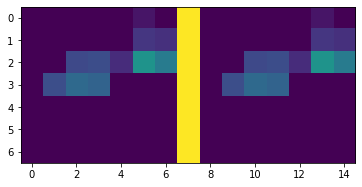

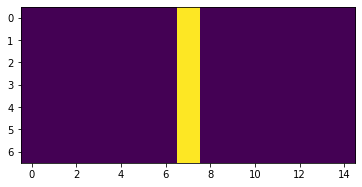

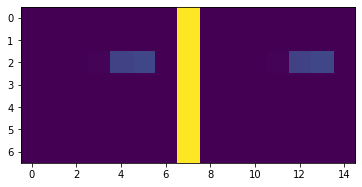

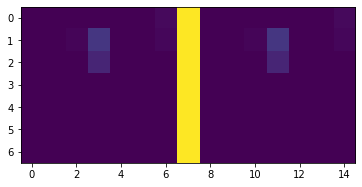

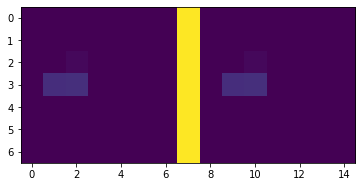

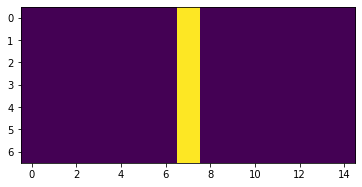

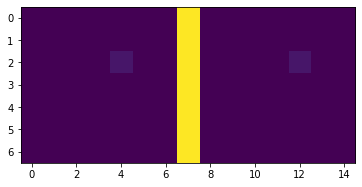

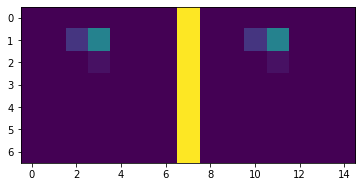

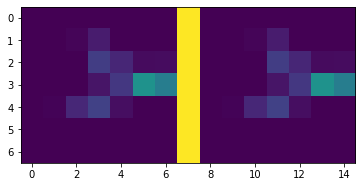

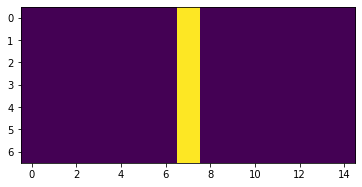

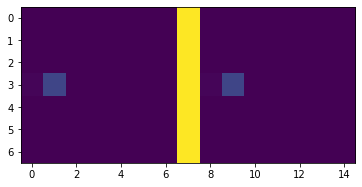

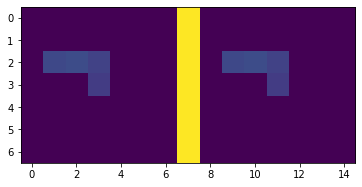

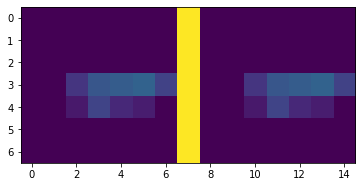

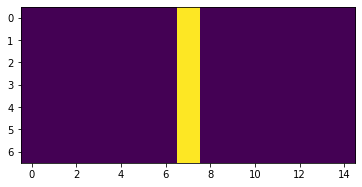

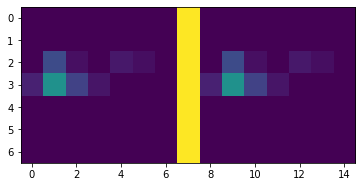

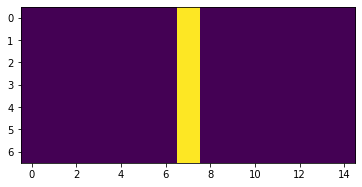

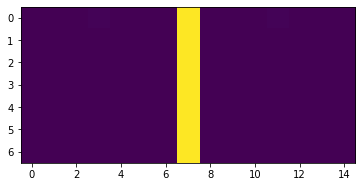

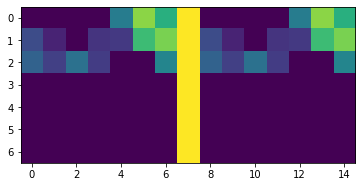

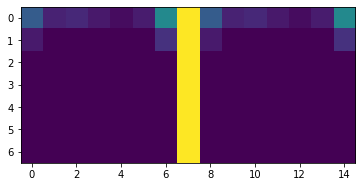

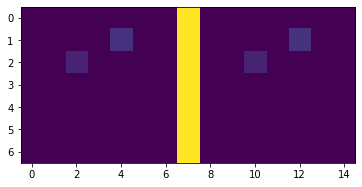

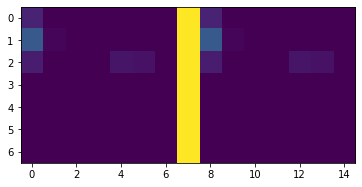

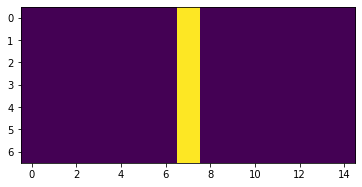

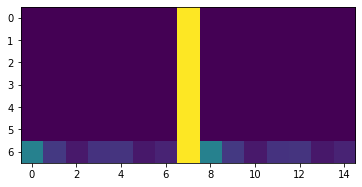

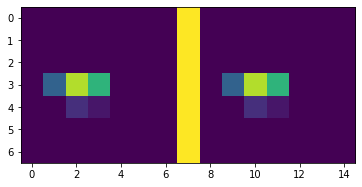

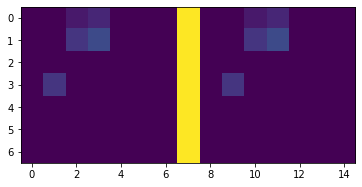

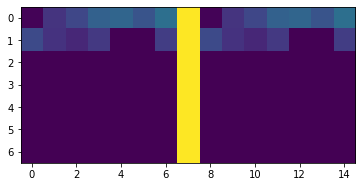

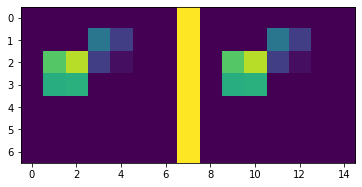

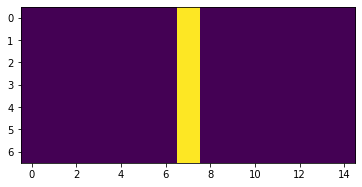

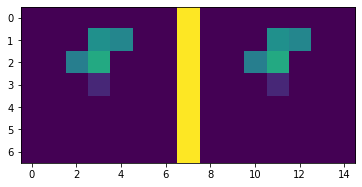

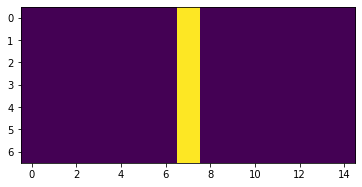

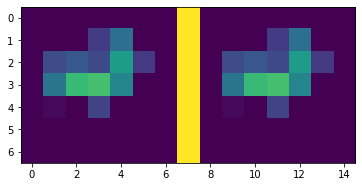

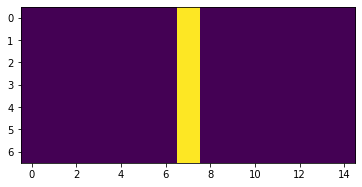

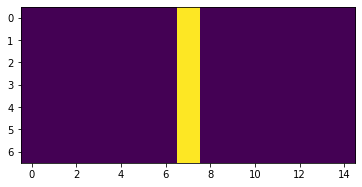

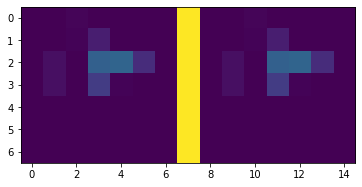

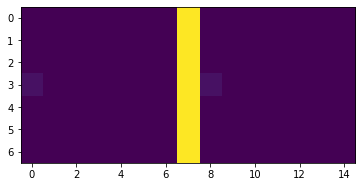

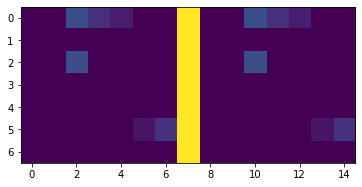

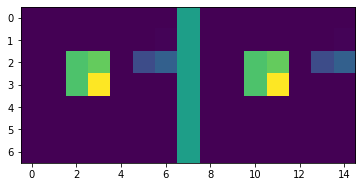

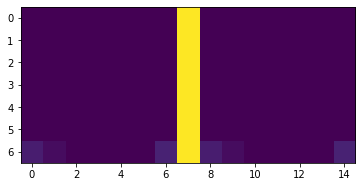

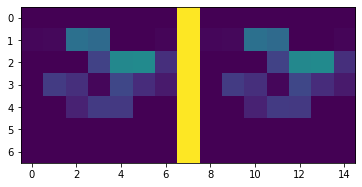

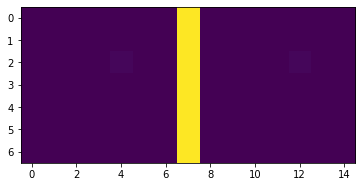

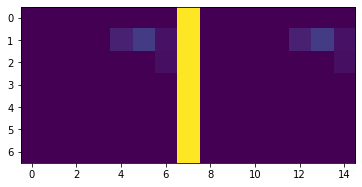

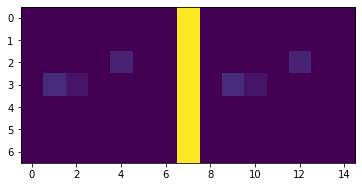

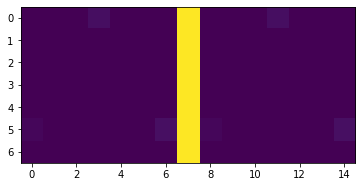

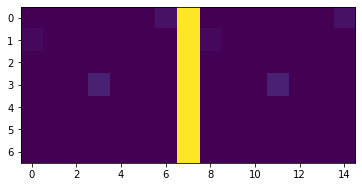

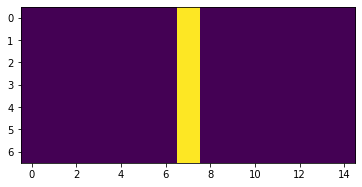

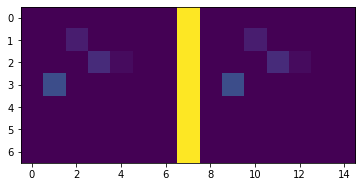

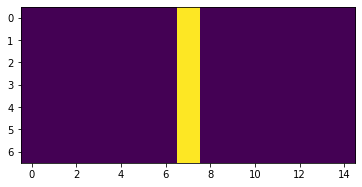

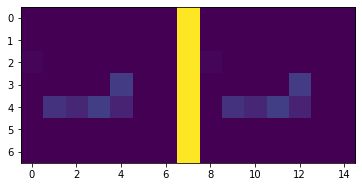

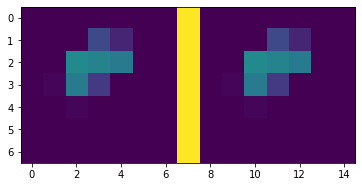

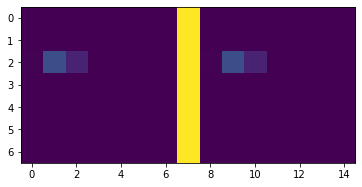

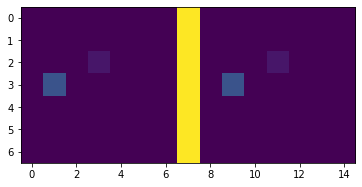

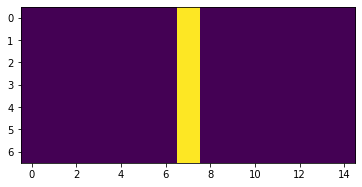

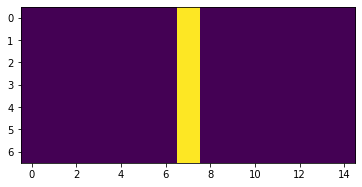

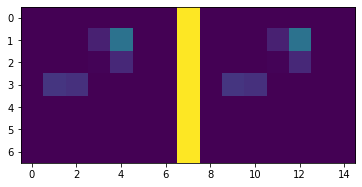

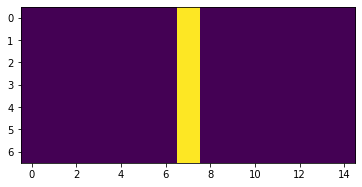

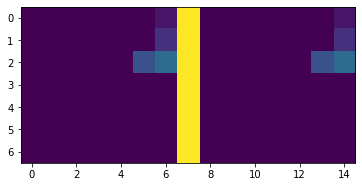

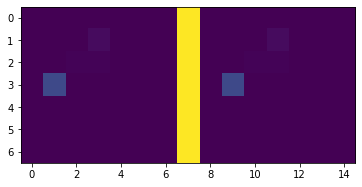

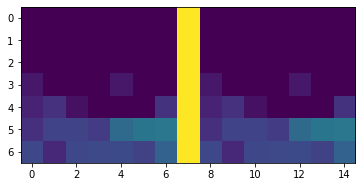

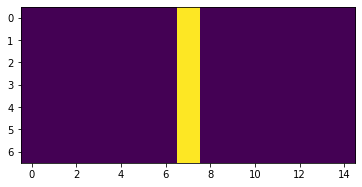

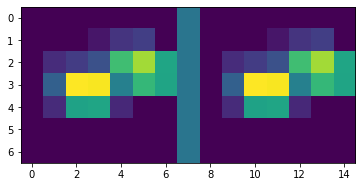

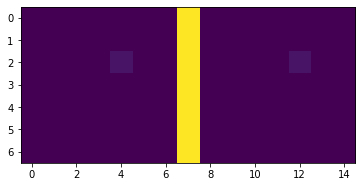

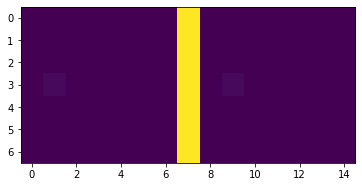

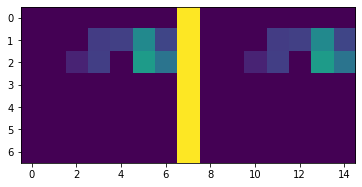

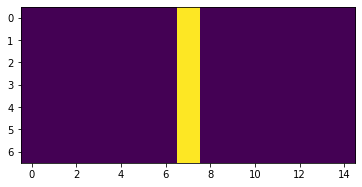

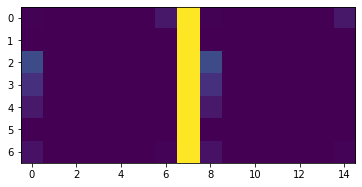

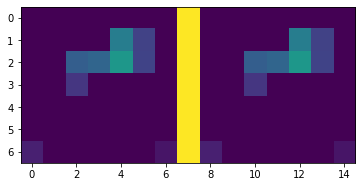

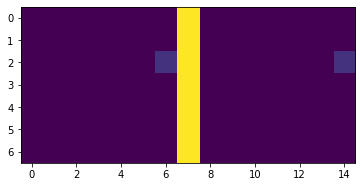

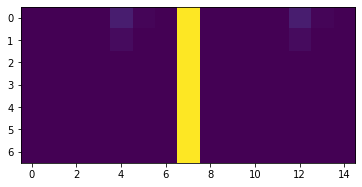

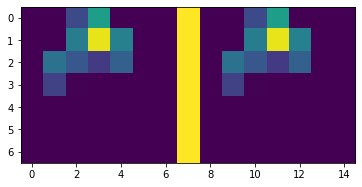

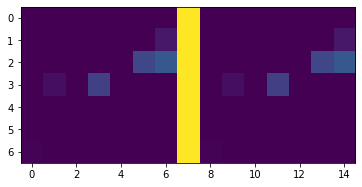

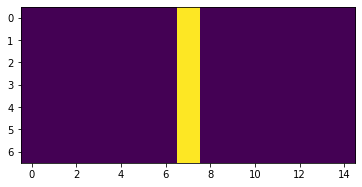

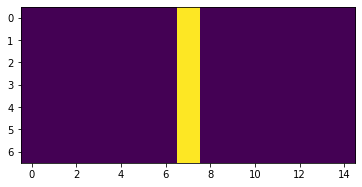

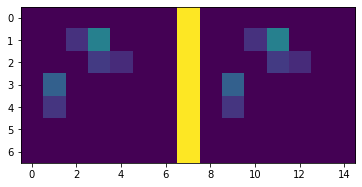

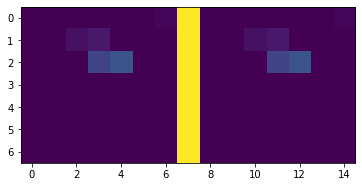

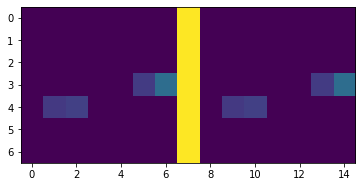

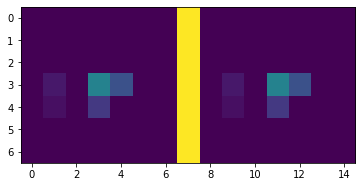

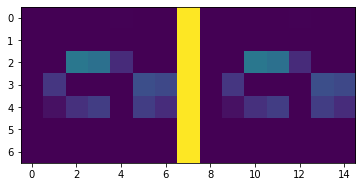

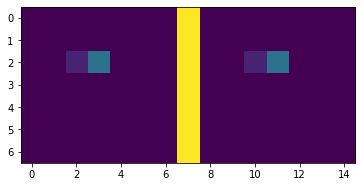

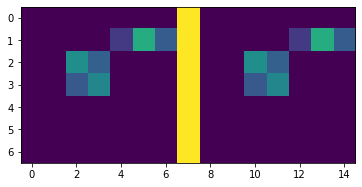

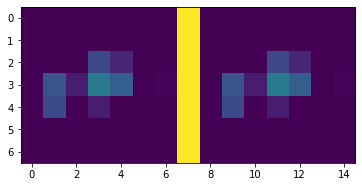

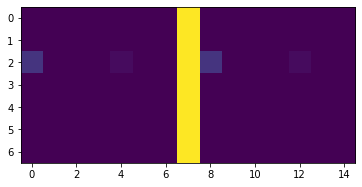

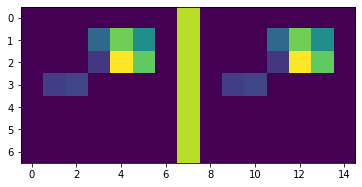

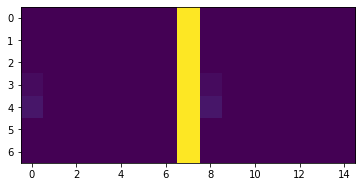

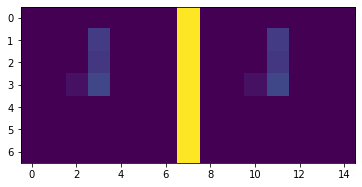

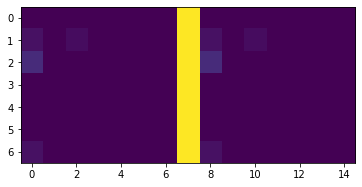

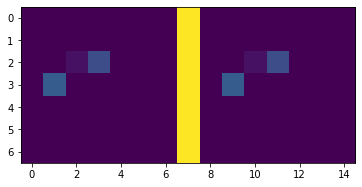

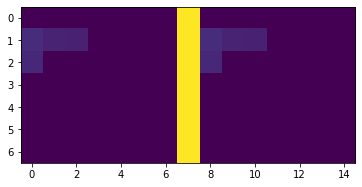

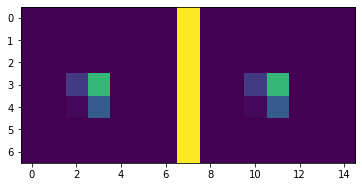

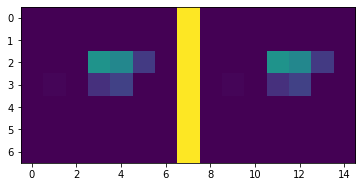

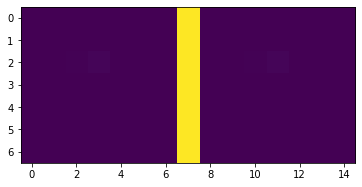

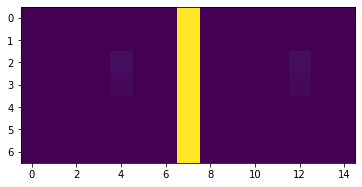

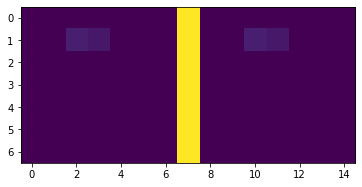

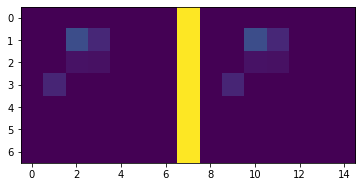

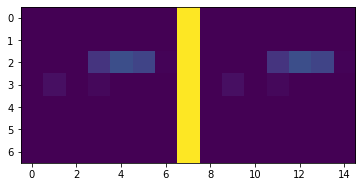

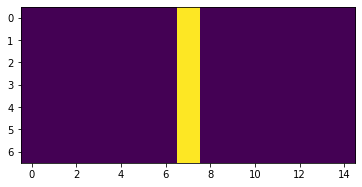

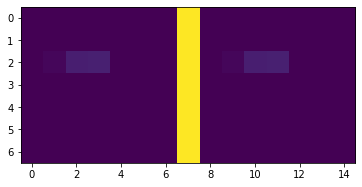

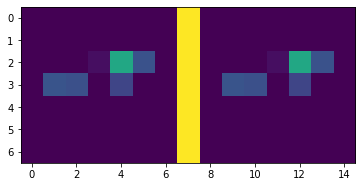

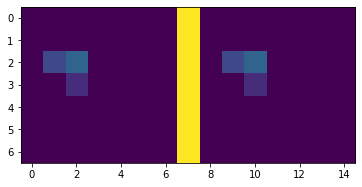

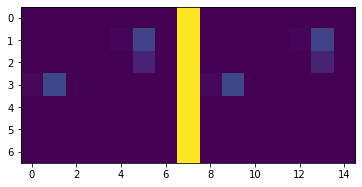

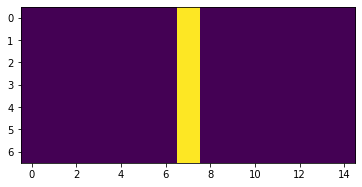

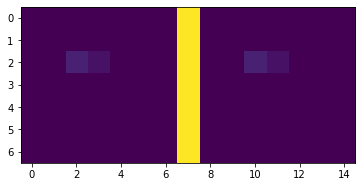

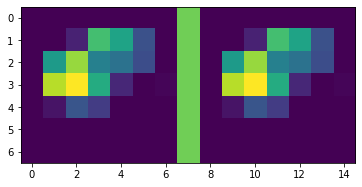

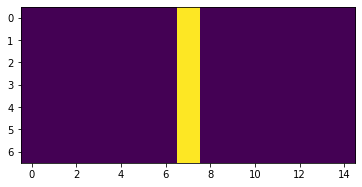

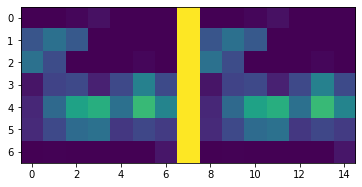

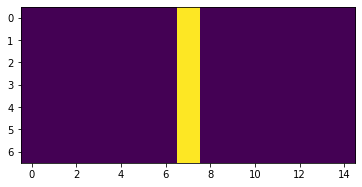

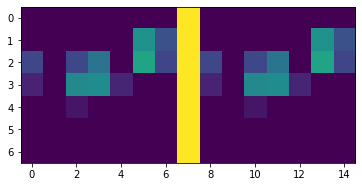

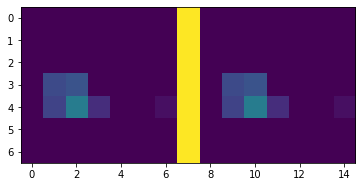

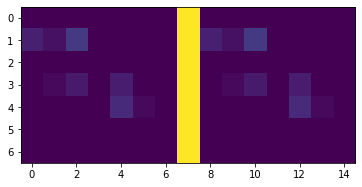

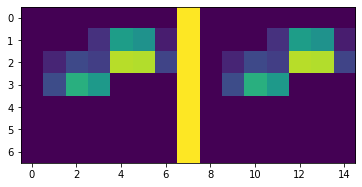

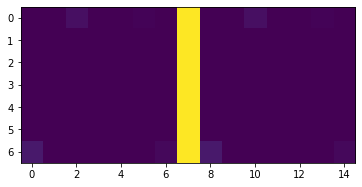

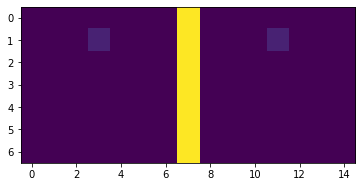

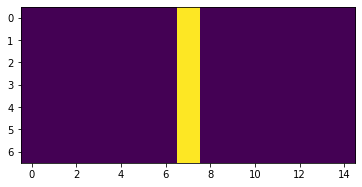

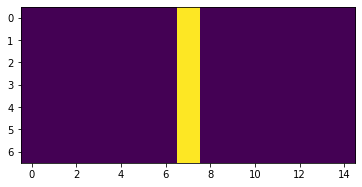

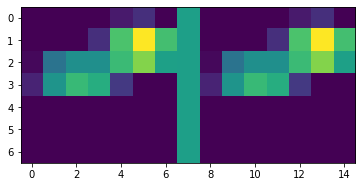

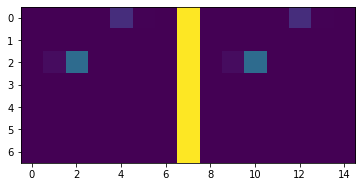

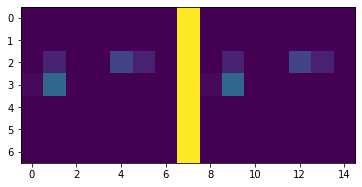

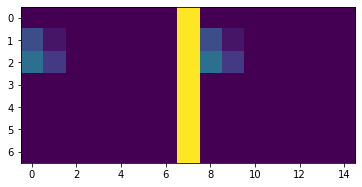

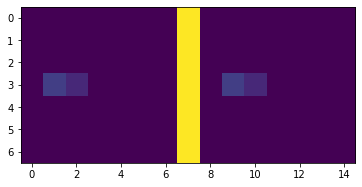

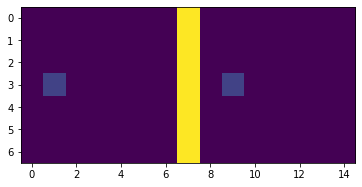

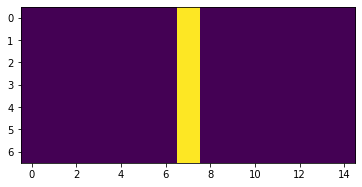

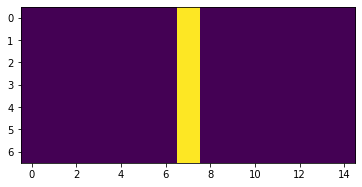

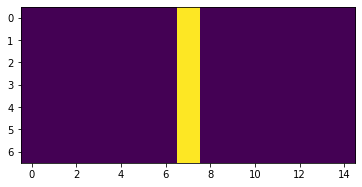

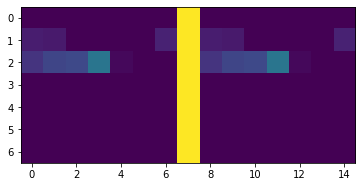

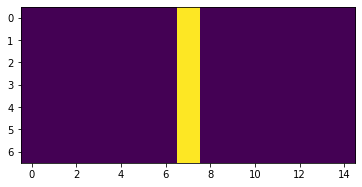

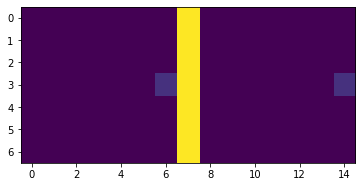

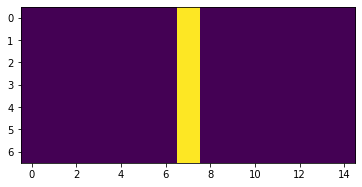

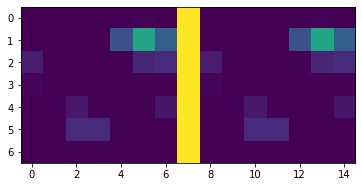

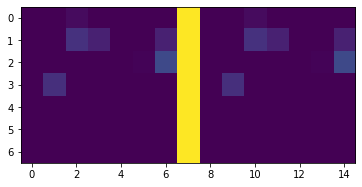

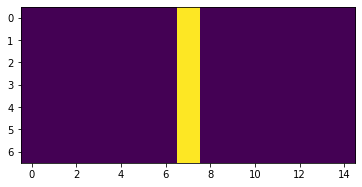

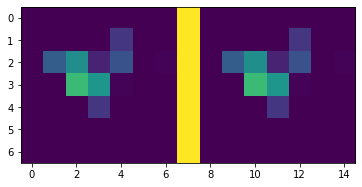

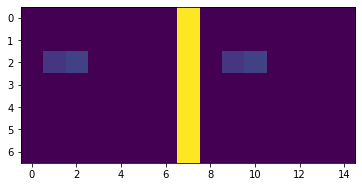

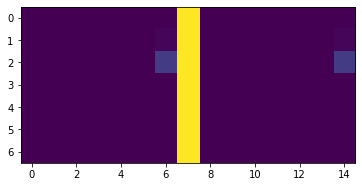

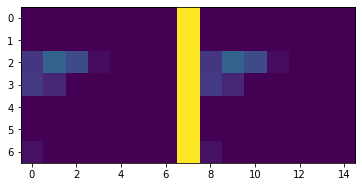

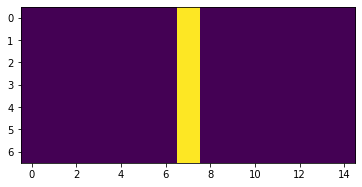

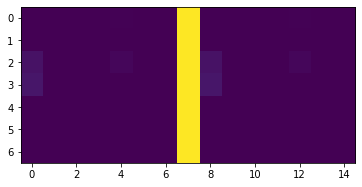

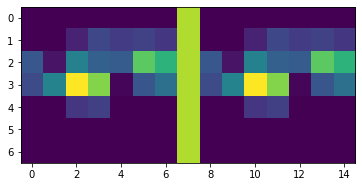

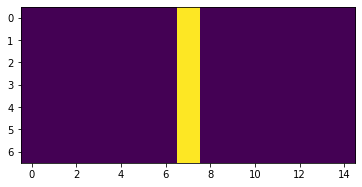

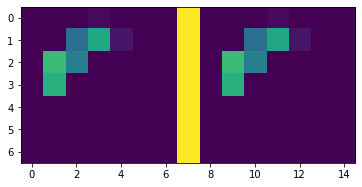

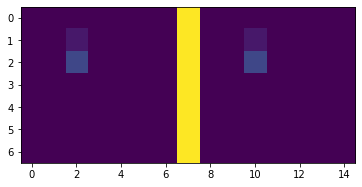

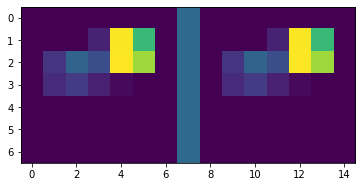

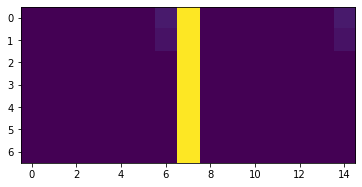

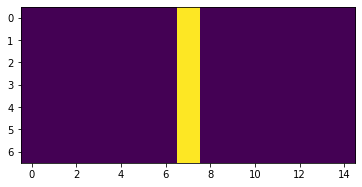

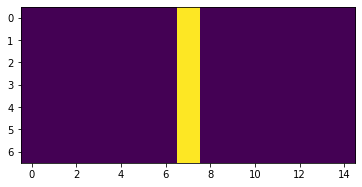

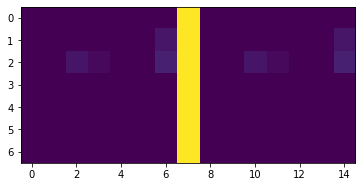

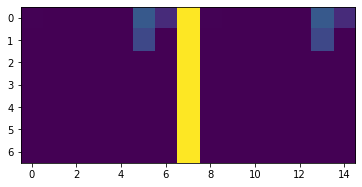

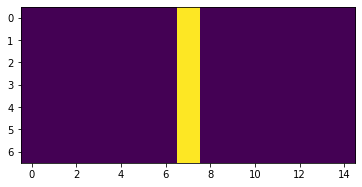

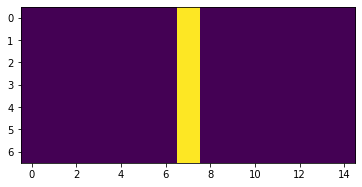

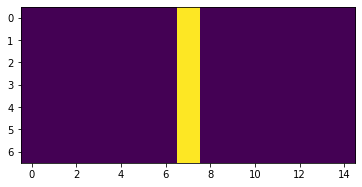

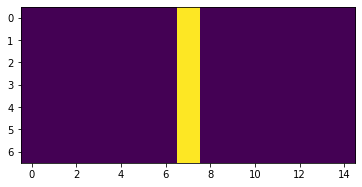

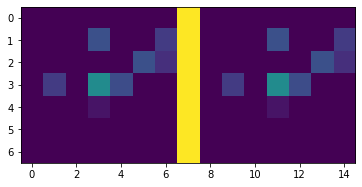

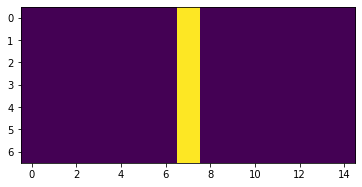

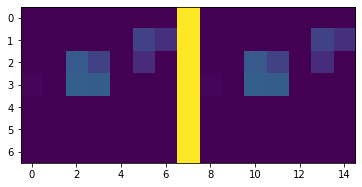

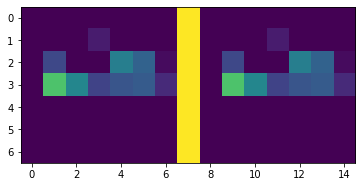

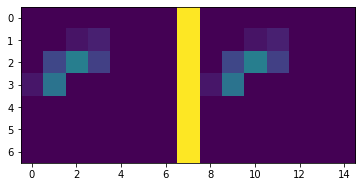

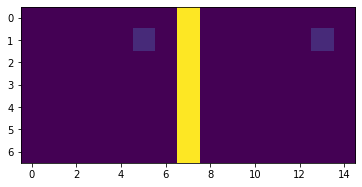

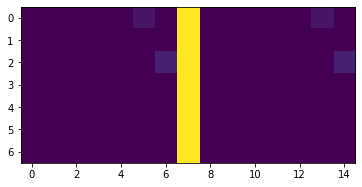

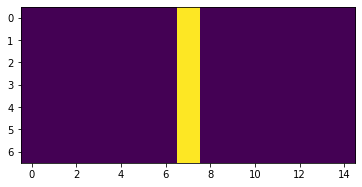

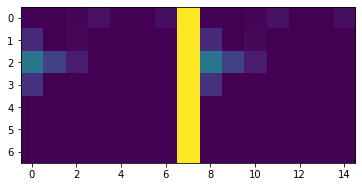

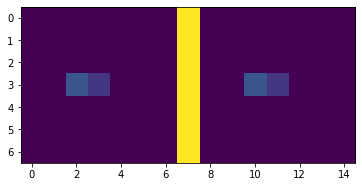

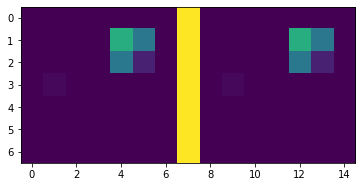

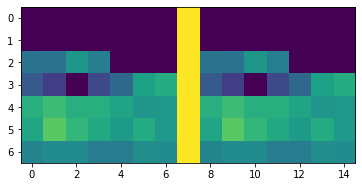

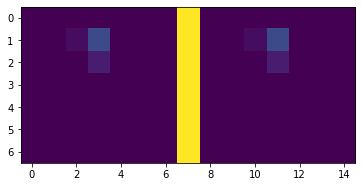

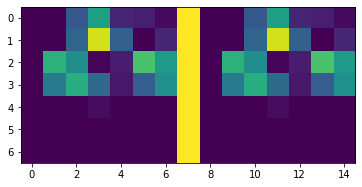

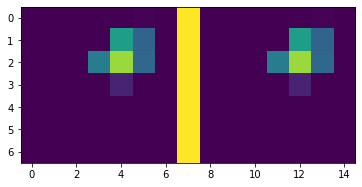

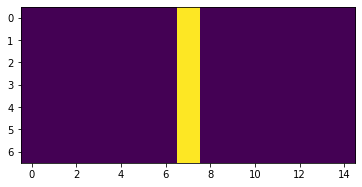

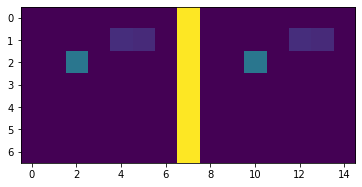

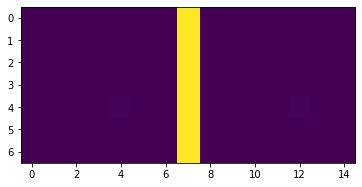

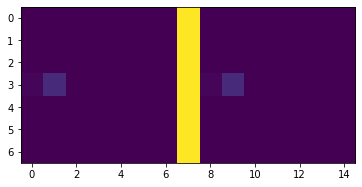

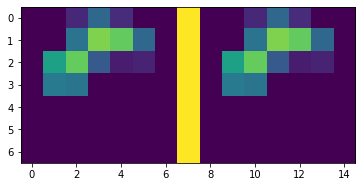

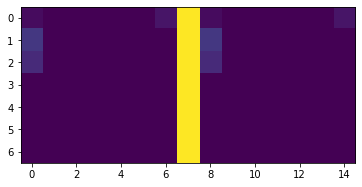

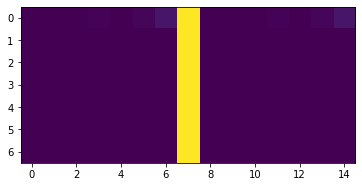

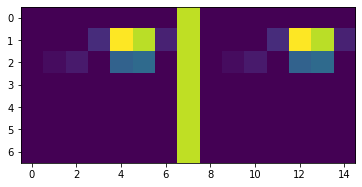

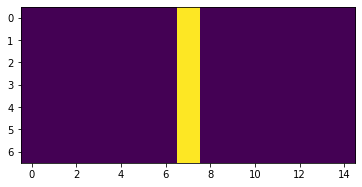

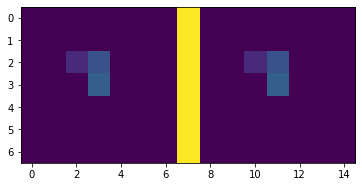

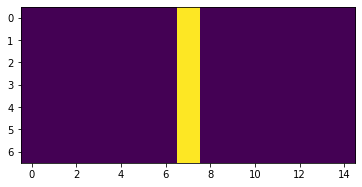

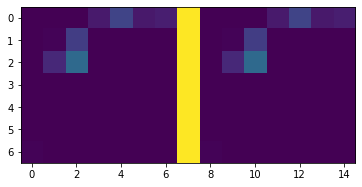

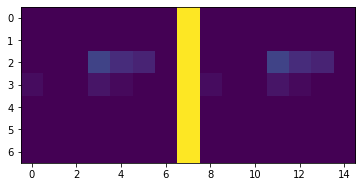

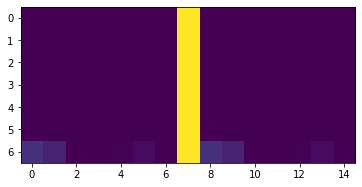

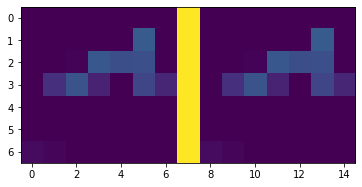

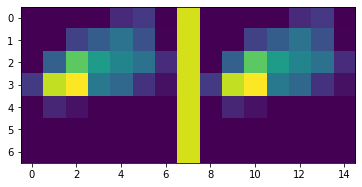

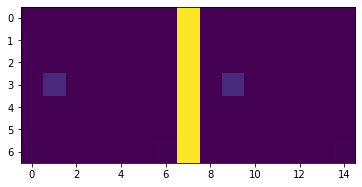

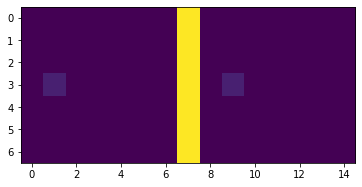

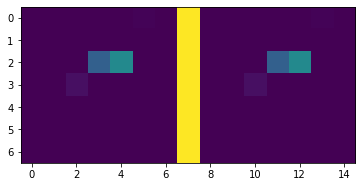

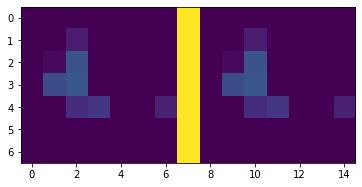

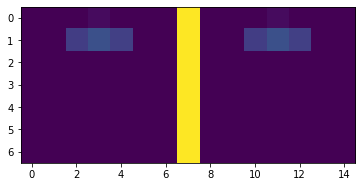

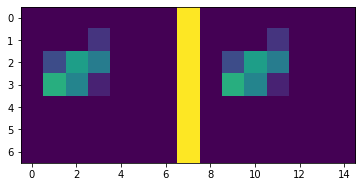

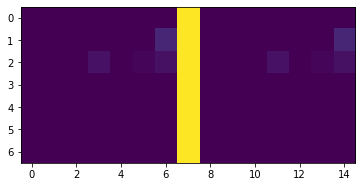

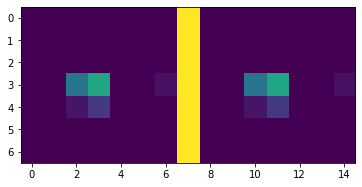

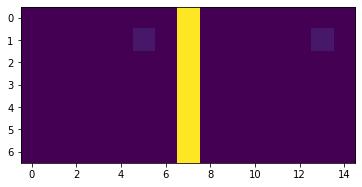

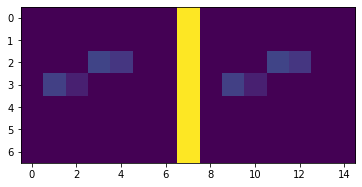

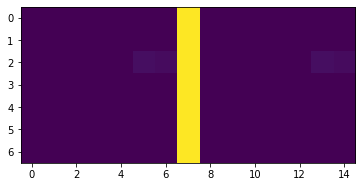

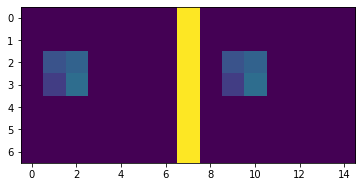

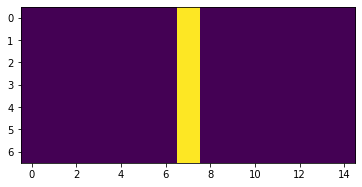

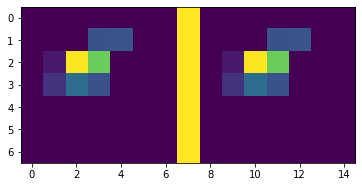

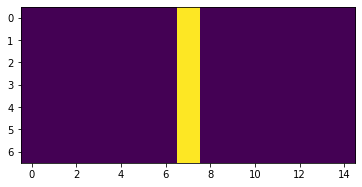

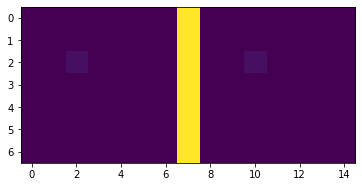

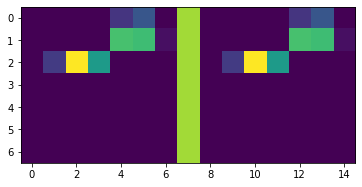

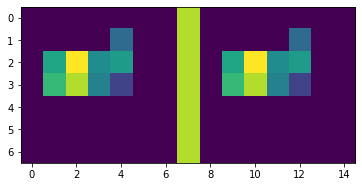

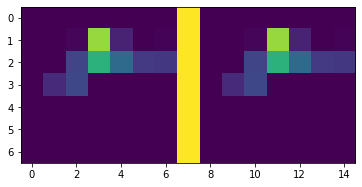

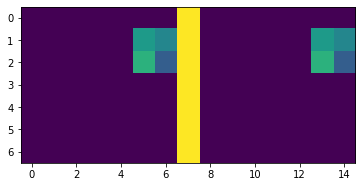

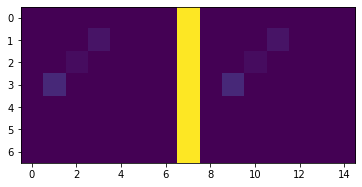

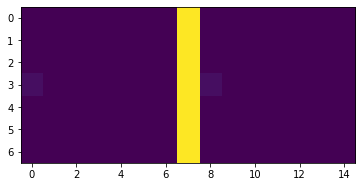

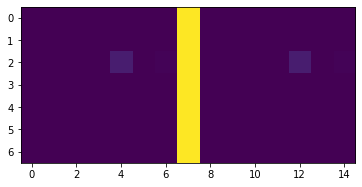

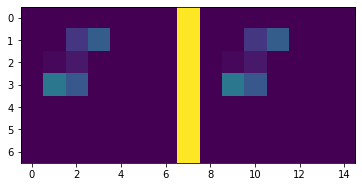

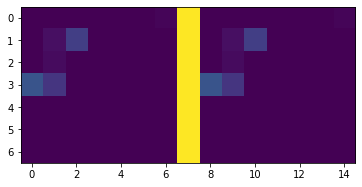

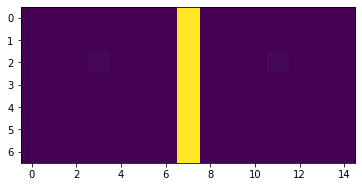

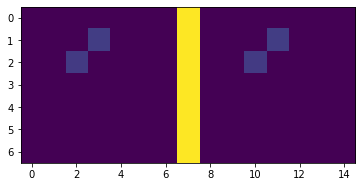

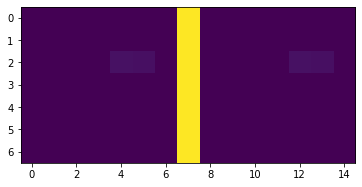

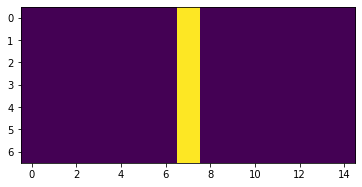

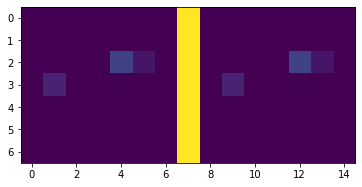

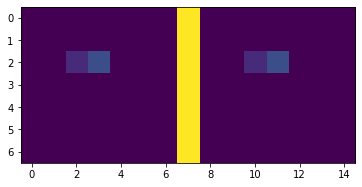

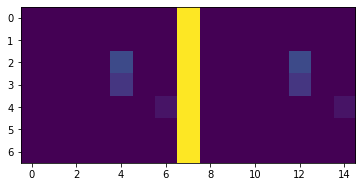

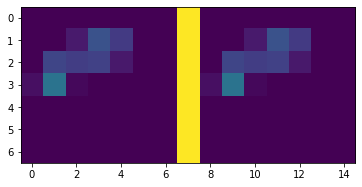

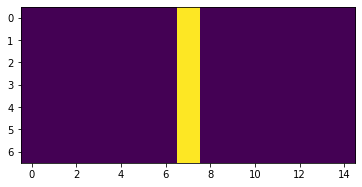

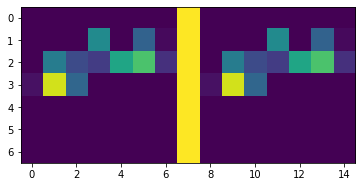

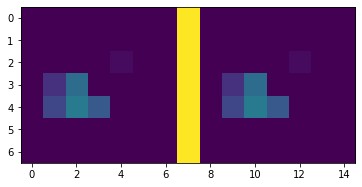

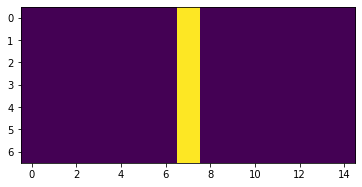

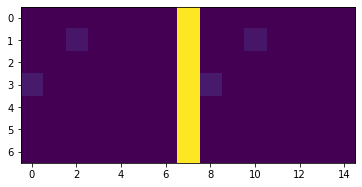

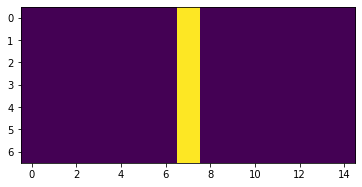

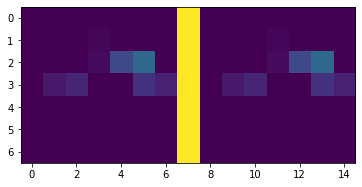

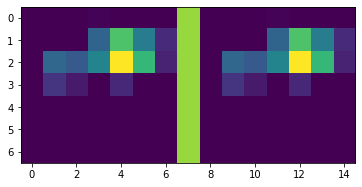

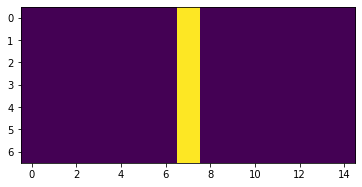

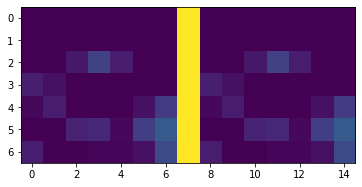

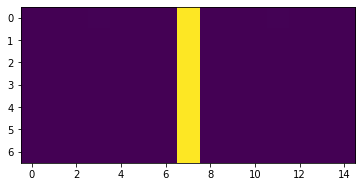

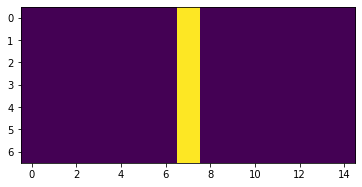

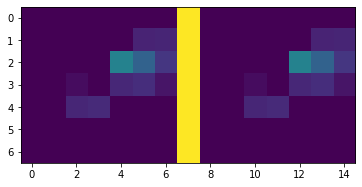

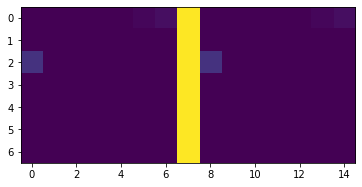

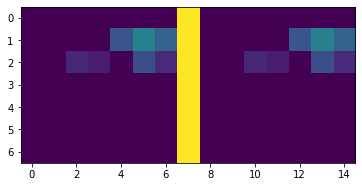

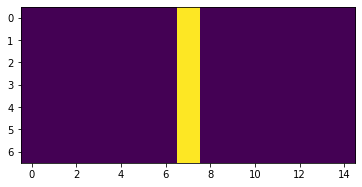

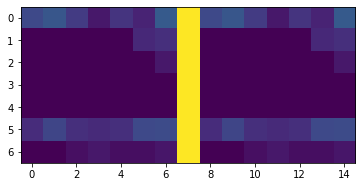

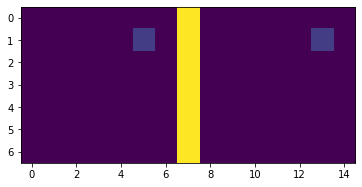

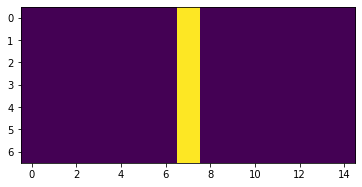

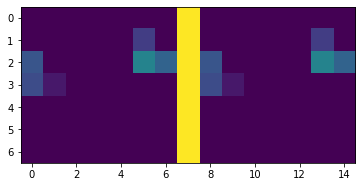

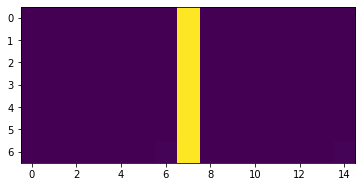

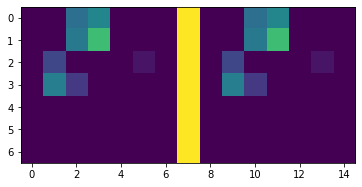

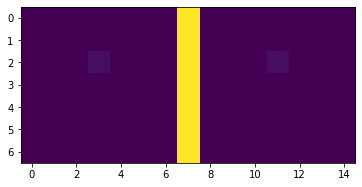

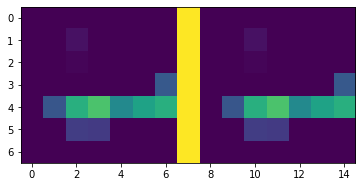

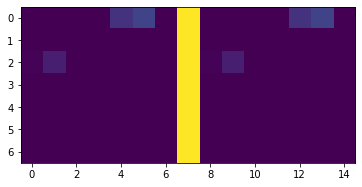

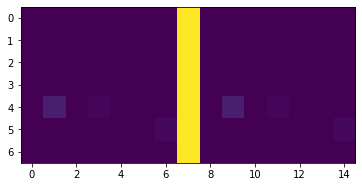

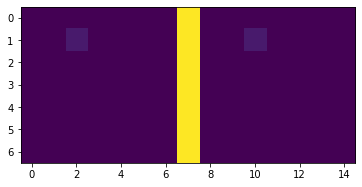

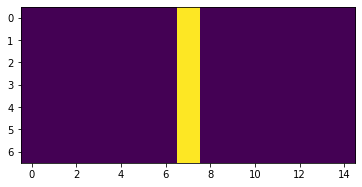

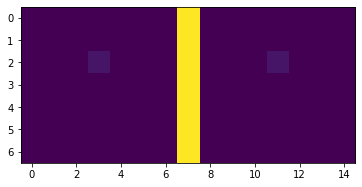

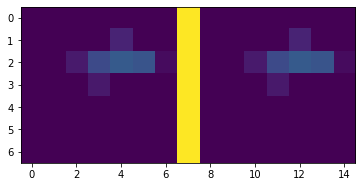

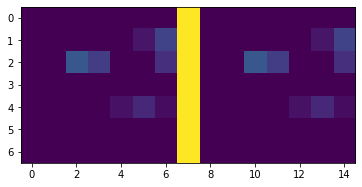

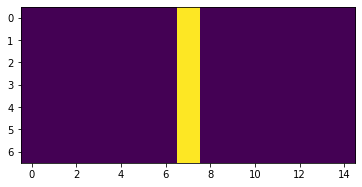

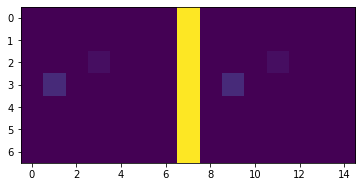

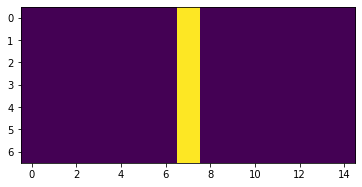

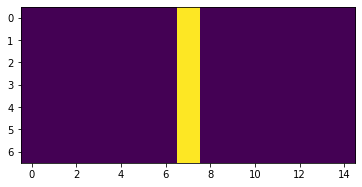

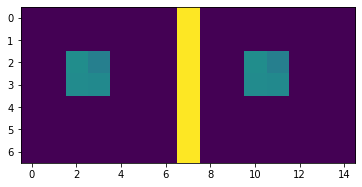

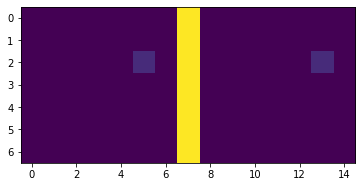

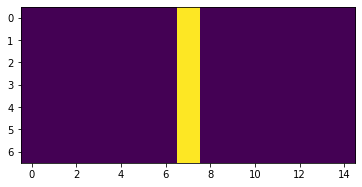

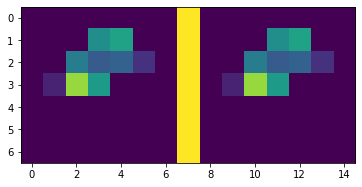

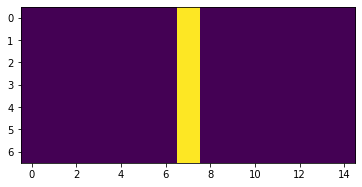

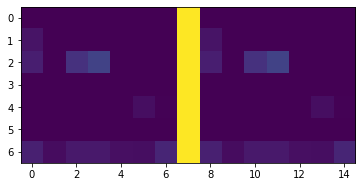

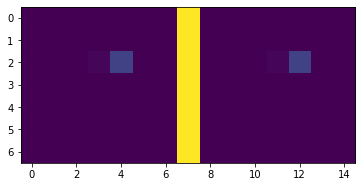

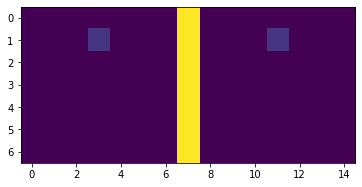

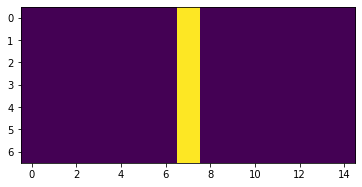

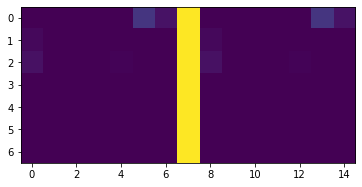

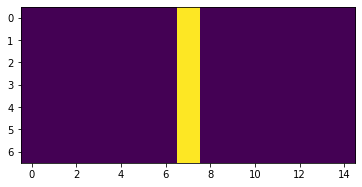

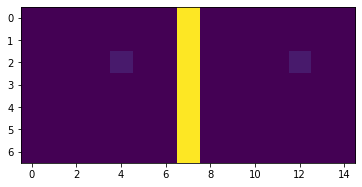

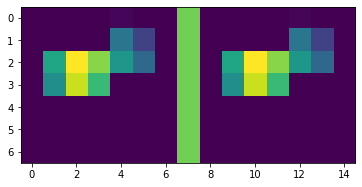

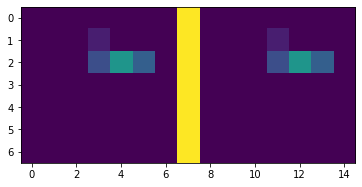

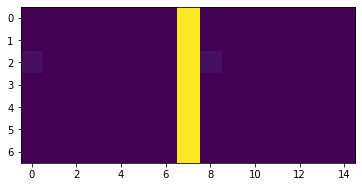

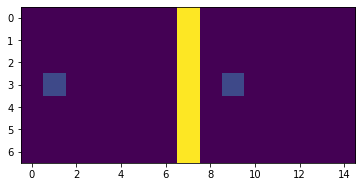

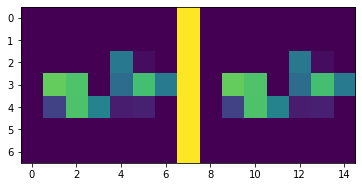

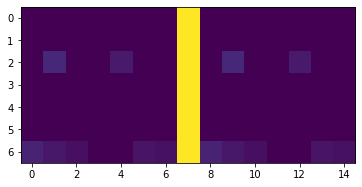

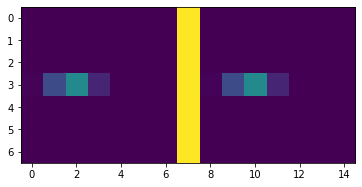

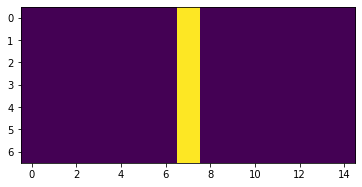

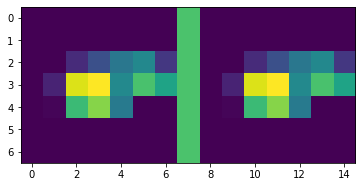

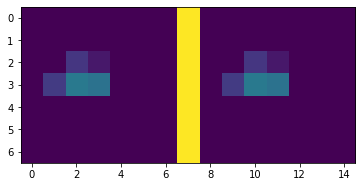

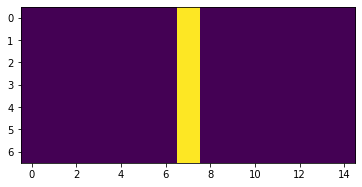

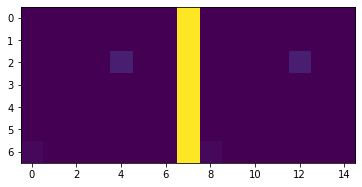

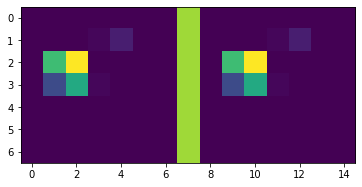

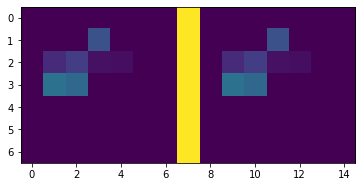

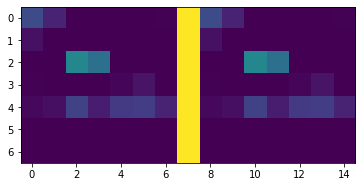

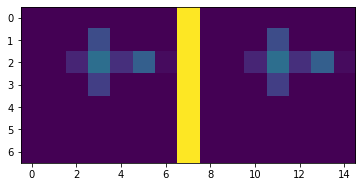

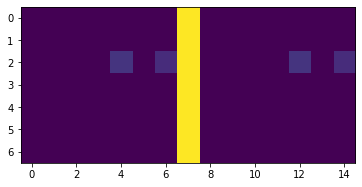

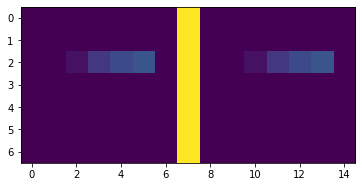

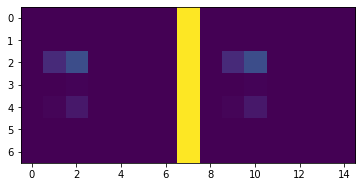

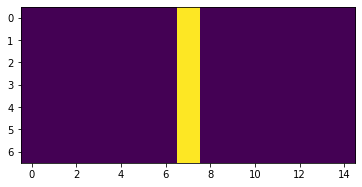

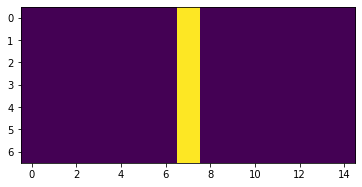

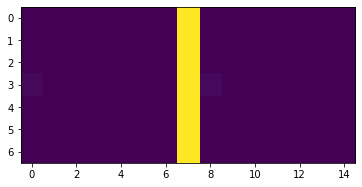

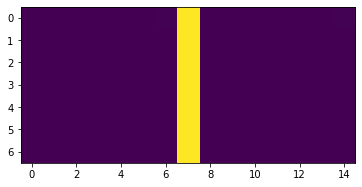

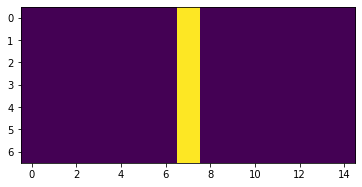

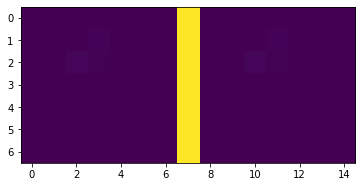

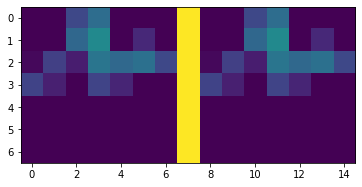

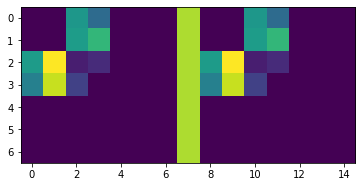

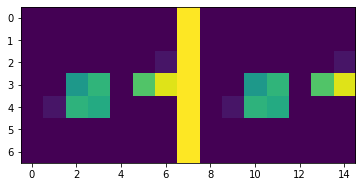

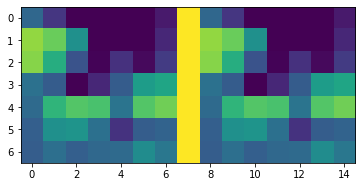

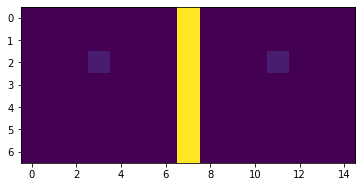

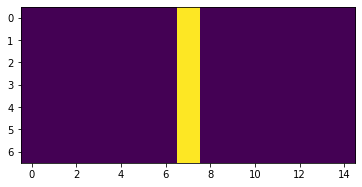

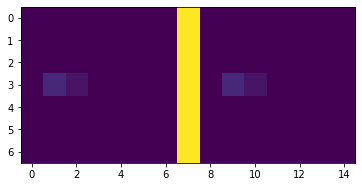

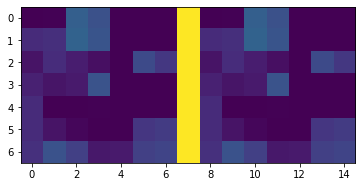

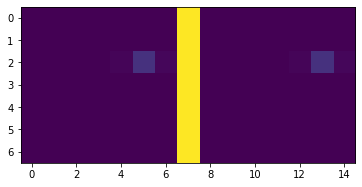

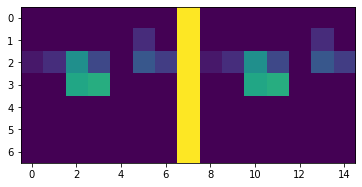

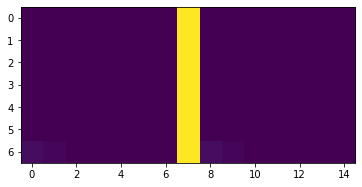

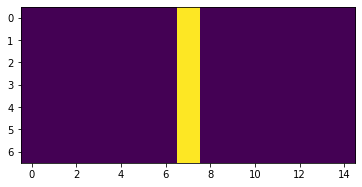

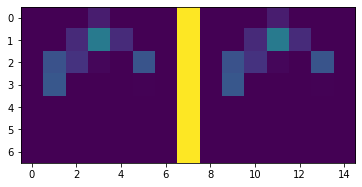

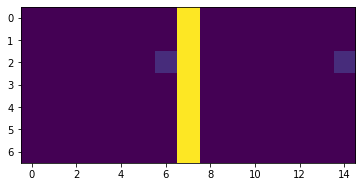

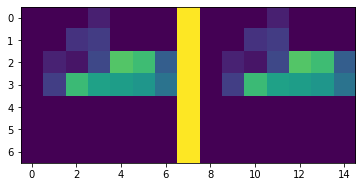

In [ ]:
import matplotlib.pyplot as plt

shape1 = features1.shape
for i in range(shape1[-1]):
  plt.figure()
  plt.imshow(features[0,:,:,i])

## Create custom UpSampling layer

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class IdxUpSampling2D(Layer):

  def __init__(self,
               size=(2,2),
               data_format=None,
               **kwargs):
    super(IdxUpSampling2D, self).__init__(
               **kwargs)
    self.size = size
    self.data_format = data_format  
  
  def get_config(self):
    config = dict(super().get_config(),
                  size = self.size,
                  data_format = self.data_format)
    return config

  def unflatten_index(self,flatidx,shape):
    #Assume includebatch: shape = (b,h,w,c)
    #Then flatidx = ((b*height + y)*width + x)*channels + c - 1
    height = shape[0]
    width = shape[1]
    channels = shape[2]
    c = flatidx%channels #Channel index
    x = (flatidx//channels)%width
    y = ((flatidx//channels)//width)
    return (y,x,c)

  def compute_output_shape(self,input_shape):
    channels = input_shape[3]
    height = self.size[0]*input_shape[1] 
    width = self.size[1]*input_shape[2] 
    batch = input_shape[0]
    output = tf.TensorShape([batch, height, width, channels])
    return output

  def build(self,input_shape):
    self.output_slice_shape = self.compute_output_slice_shape(input_shape)

  def compute_output_slice_shape(self,input_shape):
    channels = input_shape[3]
    print("channels: " + str(channels))
    height = self.size[0]*input_shape[1]
    print("height: " + str(height)) 
    width = self.size[1]*input_shape[2]
    print("width: " + str(width)) 
    #batch = tf.get_static_value(input_shape[0]) 
    output = tf.TensorShape([height, width, channels])
    print("compute_output_slice_shape output: " + str(output))
    return output

  def upsample_slice(self,idx_slice, input_slice, output_slice_shape):
    (y,x,c) = self.unflatten_index(idx_slice, output_slice_shape)
    indices_tensor = tf.transpose([y,x,c], perm=[1,2,3,0])
    indices_slice = tf.reshape(indices_tensor,[-1,3])
    input_slice = tf.reshape(input_slice,[-1,])
    output = tf.sparse.reorder(tf.SparseTensor(indices_slice, input_slice, output_slice_shape))
    output = tf.sparse.to_dense(output)
    return output

  def call(self,input_tensor, flatidx):
    input_shape = tf.shape(input_tensor)
    #output_slice_shape = self.compute_output_slice_shape(input_shape)
    output_slice_shape = self.output_slice_shape
    def f(x):
      return self.upsample_slice(x[0],x[1],output_slice_shape)
    output = tf.map_fn(f,[flatidx,input_tensor],dtype=tf.float32)
    return output

### A modest model

Tensor("arg_max_pooling2d_4/Identity_1:0", shape=(None, 2, 2, 3), dtype=int64)
Tensor("arg_max_pooling2d_4/Identity:0", shape=(None, 2, 2, 3), dtype=float32)
channels: 3
height: 4
width: 4
compute_output_slice_shape output: (4, 4, 3)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4, 4, 3)]         0         
_________________________________________________________________
arg_max_pooling2d_4 (ArgMaxP MaxPoolWithArgmax(output= 0         
_________________________________________________________________
idx_up_sampling2d_1 (IdxUpSa (None, 4, 4, 3)           0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


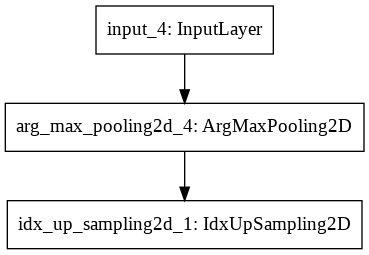

In [ ]:
modest_input = Input(shape=(4,4,3))
max_pool_2d = ArgMaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='VALID')
upsample_2d = IdxUpSampling2D(size=(2,2))

x = max_pool_2d(modest_input)
idx = x[1]
x = x[0]
print(idx)
print(x)
x = upsample_2d(x,idx)

modest = Model(modest_input,x)
modest.summary()
plot_model(modest, to_file='modest_graph.png')

### A modest test

In [ ]:
 x = tf.constant([[[[1.,1.5], [2.,2.5], [3.,3.5], [4.,4.5]],
                   [[4.,4.5], [5.,5.5], [6.,6.5], [7.,7.5]],
                   [[7.,7.5], [8.,8.5], [9.,9.5], [10,10.5]],
                   [[11.,11.5], [12.,12.5], [13.,13.5], [14,14.5]]],
                  [[[3.,3.5], [2.,2.5], [1.,1.5], [0.,0.5]],
                   [[4.,4.5], [5.,5.5], [6.,6.5], [7.,7.5]],
                   [[9.,9.5], [8.,8.5], [7.,7.5], [6.,6.5]],
                   [[2.,2.5], [3.,3.5], [4.,4.5], [8.,8.5]]]])

max_pool_2d = ArgMaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='VALID')
y = max_pool_2d(x)
input = y[0]
flatidx = y[1]
upsample_2d = IdxUpSampling2D(size=(2,2))
z = upsample_2d(input, flatidx)
print("x: " + str(x))
print("y: " + str(y))
print("z: " + str(z))


channels: 2
height: 4
width: 4
compute_output_slice_shape output: (4, 4, 2)
x: tf.Tensor(
[[[[ 1.   1.5]
   [ 2.   2.5]
   [ 3.   3.5]
   [ 4.   4.5]]

  [[ 4.   4.5]
   [ 5.   5.5]
   [ 6.   6.5]
   [ 7.   7.5]]

  [[ 7.   7.5]
   [ 8.   8.5]
   [ 9.   9.5]
   [10.  10.5]]

  [[11.  11.5]
   [12.  12.5]
   [13.  13.5]
   [14.  14.5]]]


 [[[ 3.   3.5]
   [ 2.   2.5]
   [ 1.   1.5]
   [ 0.   0.5]]

  [[ 4.   4.5]
   [ 5.   5.5]
   [ 6.   6.5]
   [ 7.   7.5]]

  [[ 9.   9.5]
   [ 8.   8.5]
   [ 7.   7.5]
   [ 6.   6.5]]

  [[ 2.   2.5]
   [ 3.   3.5]
   [ 4.   4.5]
   [ 8.   8.5]]]], shape=(2, 4, 4, 2), dtype=float32)
y: MaxPoolWithArgmax(output=<tf.Tensor: shape=(2, 2, 2, 2), dtype=float32, numpy=
array([[[[ 5. ,  5.5],
         [ 7. ,  7.5]],

        [[12. , 12.5],
         [14. , 14.5]]],


       [[[ 5. ,  5.5],
         [ 7. ,  7.5]],

        [[ 9. ,  9.5],
         [ 8. ,  8.5]]]], dtype=float32)>, argmax=<tf.Tensor: shape=(2, 2, 2, 2), dtype=int64, numpy=
array([[[[10, 11],
   

## Build decoder

In [ ]:
#Variables
x_imsize = 224
y_imsize = 224
img_size = (x_imsize,y_imsize)
n_classes = 22
epochs_model = 40

voc_root_folder = "./VOCdevkit/VOC2009"

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input
from tensorflow.keras.models import Model

img_w = 224
img_h = 224

idx_dict = dict()

kernel = (3,3)

decoding_layers = [
    #Block5_mirror 
    Conv2D(512, kernel, padding='same', name='mirror5_conv1'),
    #BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same', name='mirror5_conv2'),
    #BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel,  padding='same', name='mirror5_conv3'),
    #BatchNormalization(),
    Activation('relu'),

    #Block4_mirror
    IdxUpSampling2D(name = 'mirror5_pool'),
    Conv2D(512, kernel, padding='same', name='mirror4_conv1'),
    #BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same', name='mirror4_conv2'),
    #BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same', name='mirror4_conv3'),
    #BatchNormalization(),
    Activation('relu'),

    #Block3_mirror
    IdxUpSampling2D(name = 'mirror4_pool'),
    Conv2D(256, kernel, padding='same', name='mirror3_conv1'),
    #BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel, padding='same', name='mirror3_conv2'),
    #BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel, padding='same', name='mirror3_conv3'),
    #BatchNormalization(),
    Activation('relu'),

    #Block2_mirror
    IdxUpSampling2D(name = 'mirror3_pool'),
    Conv2D(128, kernel, padding='same', name='mirror2_conv1'),
    #BatchNormalization(),
    Activation('relu'),
    Conv2D(128, kernel, padding='same', name='mirror2_conv2'),
    #BatchNormalization(),
    Activation('relu'),

    #Block1_mirror
    IdxUpSampling2D(name = 'mirror2_pool'),
    Conv2D(64, kernel, padding='same', name='mirror1_conv1'),
    #BatchNormalization(),
    Activation('relu'),
    Conv2D(64, kernel, padding='same', name='mirror1_conv2'),
    #BatchNormalization(),
    Activation('relu'),
    IdxUpSampling2D(name = 'mirror1_pool'),
    Conv2D(n_classes, 1, 1, padding='same'),
    #BatchNormalization(),
    Activation('softmax')
]


#Build encoder part

input_tensor = Input(shape=(img_h, img_w, 3))
#Use keras functional model to rebuild the vgg model layer by layer swapping the MaxPool2D layers by ArgMaxPool2D
x = input_tensor
for layer in vgg.layers:
  layer.trainable = False
  if 'pool' in layer.name:
    argmaxname = layer.name.split('_')[0] + '_argmaxpool'
    x = ArgMaxPooling2D(pool_size=(2, 2), strides=(2,2), name=argmaxname)(x)
    idx_dict[layer.name] = x[1]
    x = x[0] #Feed the maxpooled input tensor, but not the indices
  elif 'input' in layer.name:
    continue
  else:
    x = layer(x)

#Build functional model
#input = Input(shape=(224,224,3))
#encoder.trainable = False
#x = model(input_tensor)
for layer in decoding_layers:
  if 'pool' in layer.name:
    x = layer(x, idx_dict[layer.name.replace("mirror","block")])
  else:
    x = layer(x)


model = Model(input_tensor,x)
model.summary()

channels: 512
height: 14
width: 14
compute_output_slice_shape output: (14, 14, 512)
channels: 512
height: 28
width: 28
compute_output_slice_shape output: (28, 28, 512)
channels: 256
height: 56
width: 56
compute_output_slice_shape output: (56, 56, 256)
channels: 128
height: 112
width: 112
compute_output_slice_shape output: (112, 112, 128)
channels: 64
height: 224
width: 224
compute_output_slice_shape output: (224, 224, 64)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        multiple                  1792      
_________________________________________________________________
block1_conv2 (Conv2D)        multiple                  36928     
_________________________________________________________________
block1_argmaxpool (ArgMaxPoo 

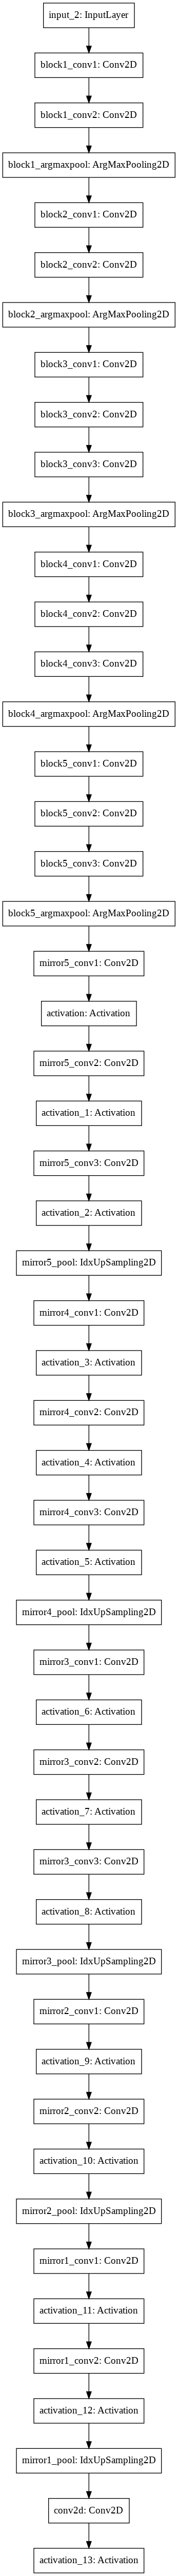

In [ ]:
plot_model(model, to_file='model_graph.png')

In [ ]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar

#Decompress from home directory 
!tar -xf VOCtrainval_11-May-2009.tar --totals


File ‘VOCtrainval_11-May-2009.tar’ already there; not retrieving.

Total bytes read: 935536640 (893MiB, 234MiB/s)


In [ ]:
import os, shutil

#START PATHS
base_path = voc_root_folder
img_start_path = os.path.join(base_path, 'JPEGImages')
mask_start_path = os.path.join(base_path, 'SegmentationClass')
train_list_path = os.path.join(base_path, 'ImageSets/Segmentation/train.txt')
trainval_list_path = os.path.join(base_path, 'ImageSets/Segmentation/trainval.txt')
val_list_path = os.path.join(base_path, 'ImageSets/Segmentation/val.txt')

print(train_list_path)
print(trainval_list_path)
print(val_list_path)

#END PATHS
train_end_path = './dataset/segmentation/train'
train_mask_end_path = './dataset/segmentation/train_masks'
trainval_end_path = './dataset/segmentation/trainval'
trainval_mask_end_path = './dataset/segmentation/trainval_masks'
val_end_path = './dataset/segmentation/val'
val_mask_end_path = './dataset/segmentation/val_masks'

def copy_segmentation_files(list_path, start_path, end_path):
    #CLEAR/CREATE END FOLDERS
    shutil.rmtree(end_path, ignore_errors=True)
    os.makedirs(end_path, exist_ok=True)
    
    startlist = os.listdir(start_path)
    ext = startlist[0][-4:]
    #READ SEGMENTATION TRAINSET LIST AND COPY FILES
    f = open(list_path, "r")
    for line in f:
        print(str(os.path.isfile(os.path.join(start_path, line[:-1] + ext)))+': '+os.path.join(start_path, line[:-1] + ext))
        if os.path.isfile(os.path.join(start_path, line[:-1] + ext)):
            shutil.copy(os.path.join(start_path, line[:-1] + ext), end_path)
    f.close()
    
#COPY IMAGES AND MASKS FROM START PATHS TO END PATHS
print('Copying segmentation training images\n')
copy_segmentation_files(train_list_path, img_start_path, train_end_path)
print('Copying segmentation training masks\n')
copy_segmentation_files(train_list_path, mask_start_path, train_mask_end_path)
print('Copying segmentation training/validation images\n')
copy_segmentation_files(trainval_list_path, img_start_path, trainval_end_path)
print('Copying segmentation training/validation masks\n')
copy_segmentation_files(trainval_list_path, mask_start_path, trainval_mask_end_path)
print('Copying segmentation validation images\n')
copy_segmentation_files(val_list_path, img_start_path, val_end_path)
print('Copying segmentation validation masks\n')
copy_segmentation_files(val_list_path, mask_start_path, val_mask_end_path)


Streaming output truncated to the last 5000 lines.
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008403.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008407.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008468.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008526.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008571.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008575.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008714.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008764.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008778.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008801.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008821.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008927.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008932.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008945.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008948.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_

### Create path lists

In [ ]:
train_input_dir = train_end_path
train_target_dir = train_mask_end_path
val_input_dir = val_end_path
val_target_dir = val_mask_end_path

train_input_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".jpg")
    ]
)
train_target_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

val_input_paths = sorted(
    [
        os.path.join(val_input_dir, fname)
        for fname in os.listdir(val_input_dir)
        if fname.endswith(".jpg")
    ]
)
val_target_paths = sorted(
    [
        os.path.join(val_target_dir, fname)
        for fname in os.listdir(val_target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of training samples:", len(train_input_paths),'\n')
print("Number of validation samples:", len(val_input_paths))

for input_path, target_path in zip(train_input_paths[:10], train_target_paths[:10]):
    print(input_path, "|", target_path)

Number of training samples: 749 

Number of validation samples: 750
./dataset/segmentation/train/2007_000032.jpg | ./dataset/segmentation/train_masks/2007_000032.png
./dataset/segmentation/train/2007_000039.jpg | ./dataset/segmentation/train_masks/2007_000039.png
./dataset/segmentation/train/2007_000063.jpg | ./dataset/segmentation/train_masks/2007_000063.png
./dataset/segmentation/train/2007_000068.jpg | ./dataset/segmentation/train_masks/2007_000068.png
./dataset/segmentation/train/2007_000121.jpg | ./dataset/segmentation/train_masks/2007_000121.png
./dataset/segmentation/train/2007_000170.jpg | ./dataset/segmentation/train_masks/2007_000170.png
./dataset/segmentation/train/2007_000241.jpg | ./dataset/segmentation/train_masks/2007_000241.png
./dataset/segmentation/train/2007_000243.jpg | ./dataset/segmentation/train_masks/2007_000243.png
./dataset/segmentation/train/2007_000250.jpg | ./dataset/segmentation/train_masks/2007_000250.png
./dataset/segmentation/train/2007_000256.jpg | ./d

In [ ]:
#Sanity check
print('Nr of train images: ' + str(len(os.listdir(train_end_path))) + '\n')
print('Nr of train masks: ' + str(len(os.listdir(train_mask_end_path))) + '\n')
print('Nr of train/validation images: ' + str(len(os.listdir(trainval_end_path))) + '\n')
print('Nr of train/validation masks: ' + str(len(os.listdir(trainval_mask_end_path))) + '\n')
print('Nr of validation images: ' + str(len(os.listdir(val_end_path))) + '\n')
print('Nr of validation masks: ' + str(len(os.listdir(val_mask_end_path))) + '\n')

Nr of train images: 749

Nr of train masks: 749

Nr of train/validation images: 1499

Nr of train/validation masks: 1499

Nr of validation images: 750

Nr of validation masks: 750



## DATA GENERATION



### Data generator class
Here I use the Sequence class from Keras instead of ImageDataGenerator. This is in order to produce customised masks that allow to:
* Either work with the 20 original Pascal-VOC-2009 object categories or to define broader categories. This is done through a for-loop that goes through each pixel of the original mask modifying the values of selected categories. 
* Ensure that the pixel value for the border regions is a consecutive integer to the object categories.
* Produce one-hot-encoding masks to be used during training with in conjunction with the categorical crossentropy loss function. 
* Resize the mask to fit the dimensions of the model's output, in case the model happened to change the resolution of the input images.

The main disadvantage of this approach is perhaps having to implement data augmentation, as it is not built in the Sequence class. This would be my next step should I have more time. I would probably use a preexisting dedicated library such as albumentations (https://github.com/albumentations-team/albumentations) or imgaug (https://github.com/aleju/imgaug)



#### 20 VOC-2009 Categories
This data generator generates masks with the original values with the exception of border pixels (value = 255) that are converted to 21 and so counted as an extra category. Therefore:
  * 0: Background pixels
  * 1-20: VOC 2009 object categories
  * 21: Border regions

In [ ]:
from tensorflow import keras
import numpy as np
import PIL
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class VOC2009SegData(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, num_classes, img_size, mask_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.img_size = img_size
        self.mask_size = mask_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) corresponding to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            img_array = img_to_array(img)
            #print ('img_array shape: ',img_array.shape)
            x[j] = img_array/255
        y = np.zeros((batch_size,) + self.mask_size + (self.num_classes,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = PIL.Image.open(path)
            img = img.resize(self.mask_size, resample=PIL.Image.NEAREST)
            img_array = np.array(img)
            img_vector = img_array.reshape((1,-1))
            #Modify this for-loop for defining generated mask categories
            for n,v in enumerate(img_vector[0]):
              if v == 255: #Set value for borders
                img_vector[0,n] = 21
              #elif v == 0: #set values for background
              #  img_vector[0,n] = 0
              #else: #set value for all the other categories (single object category)
              #  img_vector[0,n] = 1
            img_array = img_vector.reshape((img_array.shape[0], img_array.shape[1]))
            #One-hot encoding
            img_array = to_categorical(img_array, num_classes=self.num_classes)
            y[j] = img_array
        return x, y


### Instantiate data generators

In [ ]:
# Define data and mask sizes

img_size = (x_imsize, y_imsize)
batch_size = 32
#Shape of the model output (to resize mask to size)
mask_size = tuple(model.layers[-1].output.shape[1:3])

# Instantiate data Sequences for each split

train_gen = VOC2009SegData(
    batch_size, n_classes, img_size, mask_size, train_input_paths, train_target_paths
)
val_gen = VOC2009SegData(batch_size, n_classes, img_size, mask_size, val_input_paths, val_target_paths)

## TRAIN MODEL 1

In [ ]:
# Configure the model for training.
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import CategoricalCrossentropy

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001, momentum=0.9), loss="categorical_crossentropy", metrics=[MeanIoU(num_classes=n_classes)])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "/content/drive/My Drive/Segnet/Model1_23072020/Training1_epoch21_lr1e-3_mom09.h5",
        monitor = 'val_loss',
        save_best_only=True,
        ),
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
       patience = 3,
    )
]

# Train the model, doing validation at the end of each epoch.
epochs = epochs_model
hist = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

NameError: ignored

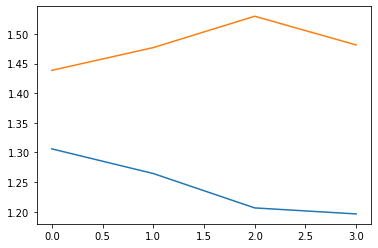

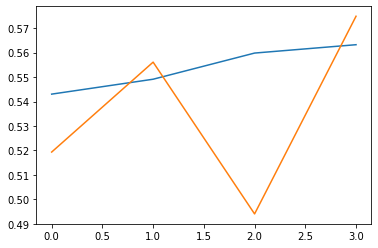

In [ ]:
import matplotlib.pyplot as plt
import pickle

history = hist.history
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure()
plt.plot('loss',data=history)
plt.plot('val_loss',data=history)
plt.figure()
plt.plot('mean_io_u_4',data=history)
plt.plot('val_mean_io_u_4',data=history)

with open('Training_1_epoch1to15_history.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

#with open('Training_1_epoch1to15_hist.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
#    pickle.dump(hist, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/Training_1_epoch1to15_hist.pickle', 'rb') as f:
  data = pickle.load(f)


FileNotFoundError: ignored

In [ ]:
data

{'loss': [2.765825033187866,
  2.1739885807037354,
  1.8703826665878296,
  1.7314648628234863,
  1.667393684387207,
  1.5943759679794312,
  1.563624382019043,
  1.5435168743133545,
  1.4849581718444824,
  1.4705475568771362,
  1.4232492446899414,
  1.4082648754119873,
  1.3604196310043335,
  1.3419251441955566,
  1.286218523979187],
 'mean_io_u_3': [0.4773513674736023,
  0.4774531126022339,
  0.4792487621307373,
  0.48146384954452515,
  0.48661643266677856,
  0.4893351197242737,
  0.4939742386341095,
  0.49866974353790283,
  0.5006137490272522,
  0.5056647062301636,
  0.5095148086547852,
  0.513721227645874,
  0.5182656049728394,
  0.5261716246604919,
  0.5350823998451233],
 'val_loss': [2.493471384048462,
  2.246537923812866,
  2.097611904144287,
  1.6660182476043701,
  1.633609652519226,
  1.611477255821228,
  1.7177233695983887,
  1.5469189882278442,
  1.5922983884811401,
  1.6132309436798096,
  1.4941409826278687,
  1.4742271900177002,
  1.5603463649749756,
  1.5779987573623657,
  